In [47]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import terratorch
import torch
import torchgeo 
import tqdm as notebook_tqdm
import json

#import geopandas as gpd
import pandas as pd

import sys
sys.path.append('../')


import utils.basics as bsc
import utils.plotting as pt
import utils.eval as eval

import importlib
importlib.reload(pt)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## load the data

In [48]:
# === Paths ===
#INPUT_FOLDER = "../data/03_training"
INPUT_FOLDER = "../data/03_training/32_withNaN"

ALS1_NORM_PARAMS = '../data/02_processed/ALS_norm_params_Site1_Ebrach.json'
ALS2_NORM_PARAMS = '../data/02_processed/ALS_norm_params_Site2_Waldbrunn.json'
ALS_NORM_PARAMS_JOINT = '../data/02_processed/ALS_norm_params_joint.json'


1. load all patches; we say 70% train; 15% val; 15% test
2. handle both sites
    1. merge; train/test/val contains same amount of data share per site
    2. separate; take one site for training, the other for testing.

In [49]:
def load_and_split_patches(site, patch_size=32, test_size=0.3, random_state=42, use_fmask=True, normalize_als=False, s2_band_indices=None):
    """
    Load S2 and ALS patches for a given site, split into train/test sets.
    Optionally normalize ALS patches for training.
    Optionally select specific S2 bands.

    Parameters:
    - site: int (1 or 2)
    - patch_size: int
    - test_size: float
    - random_state: int
    - normalize_als: bool
    - s2_band_indices: list or np.ndarray of int, optional (default: all bands)

    Returns:
    - X_train, X_test, y_train, y_test, als_mean, als_std (mean/std are None if not normalized)
    """
    s2_patches = np.load(os.path.join(INPUT_FOLDER, f"S2_site{site}_px{patch_size}.npy"))
    als_patches = np.load(os.path.join(INPUT_FOLDER, f"ALS_site{site}_px{patch_size}.npy"))
    fmask_patches = np.load(os.path.join(INPUT_FOLDER, f"FMASK_site{site}_px{patch_size}.npy"))

    if use_fmask:
        # stack fmask as the last channel to the S2 patches
        fmask_patches = fmask_patches[:, np.newaxis, :, :]  # add channel dimension
        s2_patches = np.concatenate((s2_patches, fmask_patches), axis=1)

    #print(f"Site {site}: Loaded S2 patches shape: {s2_patches.shape}, ALS patches shape: {als_patches.shape}, Fmask patches shape: {fmask_patches.shape}")
    
    if s2_band_indices is not None:
        s2_patches = s2_patches[:, s2_band_indices, :, :]

    #X_train, X_test, y_train, y_test = train_test_split(s2_patches, als_patches, test_size=test_size, random_state=random_state)
    
    # split to train, validation, and test sets
    # 70% train, 15% validation, 15% test
    X_train, X_test, y_train, y_test = train_test_split(s2_patches, als_patches, test_size=test_size, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)

    als_mean, als_std = None, None
    if normalize_als:
        als_mean = y_train.mean()
        als_std = y_train.std()
        y_train = (y_train - als_mean) / (als_std + 1e-8)
        y_test = (y_test - als_mean) / (als_std + 1e-8)
        print(f"ALS normalization: mean={als_mean:.4f}, std={als_std:.4f}")

    print(f"Site {site}: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"Site {site}: X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    print(f"Site {site}: X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    return X_train, X_val, X_test, y_train, y_val, y_test

# Example usage with all bands (default)
X_train1, X_val1, X_test1, y_train1, y_val1, y_test1 = load_and_split_patches(site=1, normalize_als=False)
X_train2, X_val2, X_test2, y_train2, y_val2, y_test2 = load_and_split_patches(site=2, normalize_als=False)

print(f"Total train patches (site 1 + 2): \t{len(X_train1) + len(X_train2)}.\n"
      f"Total val patches (site 1 + 2): \t{len(X_val1) + len(X_val2)}.\n"
      f"Total test patches (site 1 + 2): \t{len(X_test1) + len(X_test2)}. ")
# Example usage with selected bands, e.g. bands 0, 1, 2
# X_train1, X_test1, y_train1, y_test1, als_mean1, als_std1 = load_and_split_patches(site=1, normalize_als=True, s2_band_indices=[0,1,2])

Site 1: X_train shape: (308, 14, 32, 32), y_train shape: (308, 32, 32)
Site 1: X_val shape: (66, 14, 32, 32), y_val shape: (66, 32, 32)
Site 1: X_test shape: (67, 14, 32, 32), y_test shape: (67, 32, 32)
Site 2: X_train shape: (268, 14, 32, 32), y_train shape: (268, 32, 32)
Site 2: X_val shape: (57, 14, 32, 32), y_val shape: (57, 32, 32)
Site 2: X_test shape: (58, 14, 32, 32), y_test shape: (58, 32, 32)
Total train patches (site 1 + 2): 	576.
Total val patches (site 1 + 2): 	123.
Total test patches (site 1 + 2): 	125. 


In [51]:
print("Nan-Count in y_train1:", np.isnan(X_train1).sum())

Nan-Count in y_train1: 238


## lets customize site vs. train/val/test stacking
objective: stack partial sites to custom train/val/test parts

In [57]:
# write a function that stacks the training, validation, and test sets for both sites
def merge_datasets(X_train1, X_val1, X_test1, y_train1, y_val1, y_test1,
                   X_train2, X_val2, X_test2, y_train2, y_val2, y_test2):
    """
    Stack training, validation, and test sets for both sites.

    Parameters:
    - X_train1, X_val1, X_test1, y_train1, y_val1, y_test1: Site 1 datasets
    - X_train2, X_val2, X_test2, y_train2, y_val2, y_test2: Site 2 datasets

    Returns:
    - Stacked training, validation, and test sets
    """
    X_train = np.vstack((X_train1, X_train2))
    X_val = np.vstack((X_val1, X_val2))
    X_test = np.vstack((X_test1, X_test2))
    y_train = np.vstack((y_train1, y_train2))
    y_val = np.vstack((y_val1, y_val2))
    y_test = np.vstack((y_test1, y_test2))

    print("Nan-Count in X_train1:", np.isnan(X_train1).sum())
    print("Nan-Count in X_train2:", np.isnan(X_train2).sum())
    print("Nan-Count in y_train:", np.isnan(y_train).sum())
    print("Nan-Count in y_val:", np.isnan(y_val).sum())
    print("Nan-Count in y_test:", np.isnan(y_test).sum())
    print("Nan-Count in X_train1:", np.isnan(X_train1).sum())
    print("Nan-Count in X_train2:", np.isnan(X_train2).sum())
    print("Nan-Count in X_val1:", np.isnan(X_val1).sum())
    print("Nan-Count in X_val2:", np.isnan(X_val2).sum())
    print("Nan-Count in X_train:", np.isnan(X_train).sum())
    print("Nan-Count in y_train:", np.isnan(y_train).sum())

    print("We merge both sites into one training, validation, and test set.")

    print(f"Stacked X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"Stacked X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    print(f"Stacked X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Merge datasets
X_train, X_val, X_test, y_train, y_val, y_test = merge_datasets(
    X_train1, X_val1, X_test1, y_train1, y_val1, y_test1,
    X_train2, X_val2, X_test2, y_train2, y_val2, y_test2
)

Nan-Count in X_train1: 238
Nan-Count in X_train2: 318
Nan-Count in y_train: 1936
Nan-Count in y_val: 532
Nan-Count in y_test: 426
Nan-Count in X_train1: 238
Nan-Count in X_train2: 318
Nan-Count in X_val1: 0
Nan-Count in X_val2: 1
Nan-Count in X_train: 556
Nan-Count in y_train: 1936
We merge both sites into one training, validation, and test set.
Stacked X_train shape: (576, 14, 32, 32), y_train shape: (576, 32, 32)
Stacked X_val shape: (123, 14, 32, 32), y_val shape: (123, 32, 32)
Stacked X_test shape: (125, 14, 32, 32), y_test shape: (125, 32, 32)


In [58]:
print("Nan-Count in y_train:", np.isnan(X_train).sum())

Nan-Count in y_train: 556


In [12]:
def separate_datasets(X_train1, X_val1, X_test1, y_train1, y_val1, y_test1,
                        X_train2, X_val2, X_test2, y_train2, y_val2, y_test2, trainsite=1):
    """
    Train / validation from one site and testing from the other site.

    Parameters:
    - X_train1, X_val1, X_test1, y_train1, y_val1, y_test1: Site 1 datasets
    - X_train2, X_val2, X_test2, y_train2, y_val2, y_test2: Site 2 datasets

    Returns:
    - Stacked training, validation, and test sets
    """
    # Train : Site 1 Train
    # Val : Site 1 Val + Site 1 Test
    # Test: Site 2 Train + Site 2 Val + Site 2 Test

    if trainsite == 1:
        # Site 1 for training and validation, Site 2 for testing
        X_train = X_train1
        X_val = np.vstack((X_val1, X_test1))
        y_train = y_train1
        y_val = np.vstack((y_val1, y_test1))
        # Use Site 2 for testing
        X_test = np.vstack((X_train2, X_val2, X_test2))
        y_test = np.vstack((y_train2, y_val2, y_test2))
    elif trainsite == 2:
        # Site 2 for training and validation, Site 1 for testing
        X_train = X_train2
        X_val = np.vstack((X_val2, X_test2))
        y_train = y_train2
        y_val = np.vstack((y_val2, y_test2))
        # Use Site 1 for testing
        X_test = np.vstack((X_train1, X_val1, X_test1))
        y_test = np.vstack((y_train1, y_val1, y_test1))

    print(f"We use Site {trainsite} for training and validation and test on Site {3 - trainsite}.") 
    print(f"Stacked X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"Stacked X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    print(f"Stacked X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [13]:
if False:
    X_train, X_val, X_test, y_train, y_val, y_test = separate_datasets(
        X_train1, X_val1, X_test1, y_train1, y_val1, y_test1,
        X_train2, X_val2, X_test2, y_train2, y_val2, y_test2
    )

### sequential learning
1. train with site 1
2. use same model, retrain with site 2
--> does it get any better? 

In [ ]:
pretrainmode = False
finetrainmode = False #not(pretrainmode)

if pretrainmode:
    # first iteration
    #X_train, X_val, X_test, y_train, y_val, y_test = X_train1, X_val1, X_test1, y_train1, y_val1, y_test1
    X_train, X_val, X_test, y_train, y_val, y_test = X_train2, X_val2, X_test2, y_train2, y_val2, y_test2
if finetrainmode:
    # second iteration
    #X_train, X_val, X_test, y_train, y_val, y_test = X_train2, X_val2, X_test2, y_train2, y_val2, y_test2
    X_train, X_val, X_test, y_train, y_val, y_test = X_train1, X_val1, X_test1, y_train1, y_val1, y_test1


In [53]:
X_train.shape

(576, 14, 32, 32)

## sketch the U-Net architecture. 

In [54]:
# Central hyperparameter config as default

config = {
    'patch_size': 32,
    'num_bands': 15,        # change based on input (13+1 for fmask, +1 for mask channel)
    'batch_size': 64,
    'lr': 1e-3,
    'weight_decay': 3e-4,
    'momentum': 0.9,
    'epochs': 250,
    'huber_delta': 0.2,
    'device':  'mps' if torch.backends.mps.is_available() else 'cpu'
}

In [59]:
class S2CanopyHeightDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()               # (N, num_bands, 32, 32)
        self.y = torch.from_numpy(y).float().unsqueeze(1)  # (N, 1, 32, 32)
        # NaN mask across bands → shape: (N, 1, 32, 32)
        # A pixel is valid if *not all bands* in X are NaN and y is not NaN
        x_valid = ~torch.isnan(self.X).any(dim=1, keepdim=True)  # (N, num_bands, 32, 32)
        y_valid = ~torch.isnan(self.y)                           # (N, 1, 32, 32)
        self.mask = x_valid & y_valid

        # Replace NaNs in input with -1.0 or some other value
        self.X[torch.isnan(self.X)] = -1.0 
        self.y[torch.isnan(self.y)] = -1.0 
    def __len__(self):
        return self.X.shape[0]
    # def __getitem__(self, idx):
    #     return self.X[idx], self.y[idx]
    def __getitem__(self, idx):
        x = self.X[idx]                         # (num_bands, 32, 32)
        m = self.mask[idx].float()             # (1, 32, 32)
        x_with_mask = torch.cat([x, m], dim=0) # (num_bands + 1, 32, 32)
        return x_with_mask, self.y[idx], self.mask[idx]  # keep mask for loss too
    def __getstats__(self):
        """
        Returns the mean and std of the dataset.
        """
        # Calculate mean and std only for valid (non-NaN) areas using the mask
        valid_y = self.y[self.mask]
        mean = torch.mean(valid_y)
        std = torch.std(valid_y)
        return mean.item(), std.item()
    def __getdistr__(self):
        """
        Returns the distribution of the dataset.
        """
        # Calculate distribution of valid (non-NaN) areas using the mask
        valid_y = self.y[self.mask].flatten()
        hist, bin_edges = np.histogram(valid_y.cpu().numpy(), bins=50, density=True)
        return hist, bin_edges

# Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
train_dataset = S2CanopyHeightDataset(X_train, y_train)
val_dataset = S2CanopyHeightDataset(X_val, y_val)
test_dataset = S2CanopyHeightDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'])

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels=1, dropout=0.2):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Dropout2d(dropout),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Dropout2d(dropout)
            )

        self.encoder1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(128, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        bottleneck = self.bottleneck(self.pool2(enc2))
        dec2 = self.decoder2(torch.cat([self.upconv2(bottleneck), enc2], dim=1))
        dec1 = self.decoder1(torch.cat([self.upconv1(dec2), enc1], dim=1))
        return self.final(dec1)

# For debugging: set mask to all ones to match nn.HuberLoss behavior
def masked_huber_loss(pred, target, mask, delta=config['huber_delta']):
    """
    Computes the masked Huber loss (Smooth L1 loss).
    If mask is all ones, this should match nn.HuberLoss.
    """
    # Uncomment the next line to force mask to all ones for testing
    #mask = torch.ones_like(target)
    mask = mask.float()
    error = pred - target
    abs_error = torch.abs(error)

    quadratic = torch.minimum(abs_error, torch.tensor(delta, device=pred.device))
    linear = abs_error - quadratic

    loss = 0.5 * quadratic**2 + delta * linear
    masked_loss = loss * mask

    return masked_loss.sum() / mask.sum().clamp(min=1)


### new loss functions

In [67]:
import torch.nn.functional as F

def edge_sensitive_huber_loss(pred, target, mask, delta=config['huber_delta'], edge_weight=2.0):
    """
    Edge-sensitive masked Huber loss.
    Errors at edges (in target) are weighted higher.
    """
    # Compute Sobel edges on target
    sobel_x = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=target.dtype, device=target.device).view(1,1,3,3)
    sobel_y = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=target.dtype, device=target.device).view(1,1,3,3)
    # target: (N, 1, H, W)
    edge_x = F.conv2d(target, sobel_x, padding=1)
    edge_y = F.conv2d(target, sobel_y, padding=1)
    edge_mag = torch.sqrt(edge_x**2 + edge_y**2)
    # Normalize edge magnitude to [0,1]
    edge_mask = (edge_mag > edge_mag.mean()).float()
    # Weight: edge_weight at edges, 1 elsewhere
    weights = 1.0 + (edge_weight - 1.0) * edge_mask

    # Standard masked Huber loss
    mask = mask.float()
    error = pred - target
    abs_error = torch.abs(error)
    quadratic = torch.minimum(abs_error, torch.tensor(delta, device=pred.device))
    linear = abs_error - quadratic
    loss = 0.5 * quadratic**2 + delta * linear

    # Apply edge weights and mask
    weighted_loss = loss * weights * mask
    return weighted_loss.sum() / (weights * mask).sum().clamp(min=1)


In [8]:
def frequency_weighted_huber_loss(pred, target, mask, hist, bin_edges, delta=config['huber_delta'], max_weight=10.0, tail_factor=2.0):
    """
    Masked Huber loss with frequency-based reweighting using a histogram.
    Each pixel is weighted by the inverse frequency of its target value in the training set.
    """
    # Flatten target and mask
    target_flat = target.view(-1)
    mask_flat = mask.view(-1).float()

    # Digitize target values to histogram bins
    bin_indices = np.digitize(target_flat.cpu().numpy(), bin_edges) - 1
    bin_indices = np.clip(bin_indices, 0, len(hist) - 1)
    # Get frequency for each target value
    freq = hist[bin_indices].astype(np.float32)
    freq = torch.from_numpy(freq).to(target.device).float()

    # Inverse frequency as weight, upweighting rare values
    weights = (1.0 / (freq + 1e-8)) ** tail_factor
    weights = weights / weights.mean()
    weights = torch.clamp(weights, max=max_weight)

    # Standard masked Huber loss
    error = pred.view(-1) - target_flat
    abs_error = torch.abs(error)
    quadratic = torch.minimum(abs_error, torch.tensor(delta, device=pred.device))
    linear = abs_error - quadratic
    loss = 0.5 * quadratic**2 + delta * linear

    # Apply weights and mask
    weighted_loss = loss * weights * mask_flat
    return weighted_loss.sum() / (weights * mask_flat).sum().clamp(min=1)


## edge sensitive loss

### training edge sensitive

In [58]:
!pip install optuna --quiet
import optuna

def objective(trial):
    # Suggest hyperparameters
    batch_size = trial.suggest_categorical('batch_size', [64])
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    momentum = trial.suggest_float('momentum', 0.6, 0.99)
    #huber_delta = trial.suggest_float('huber_delta', 0.2,0.2)
    edge_weight = trial.suggest_float('edge_weight', 1.0, 1.2)
    max_weight = trial.suggest_float('max_weight', 1.0, 15.0)

    # Update config
    config.update({
        'batch_size': batch_size,
        'lr': lr,
        'weight_decay': weight_decay,
        'momentum': momentum,
        #'huber_delta': huber_delta,
        'edge_weight': edge_weight
    })

    # Re-create loaders with new batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Model, optimizer, loss
    model = UNet(config['num_bands']).to(config['device'])
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = edge_sensitive_huber_loss

    # Training loop (short for tuning)
    epochs = 25
    for epoch in range(epochs):
        model.train()
        for inputs, targets, mask in train_loader:
            inputs, targets, mask = inputs.to(config['device']), targets.to(config['device']), mask.to(config['device'])
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets, mask, delta=config['huber_delta'], edge_weight=edge_weight)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets, mask in val_loader:
                inputs, targets, mask = inputs.to(config['device']), targets.to(config['device']), mask.to(config['device'])
                outputs = model(inputs)
                loss = criterion(outputs, targets, mask, delta=config['huber_delta'], edge_weight=edge_weight)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss

study = optuna.create_study(direction='minimize',)
study.optimize(objective, n_trials=50,)

print("Best parameters:")
print(study.best_params)
print(f"Best validation loss: {study.best_value:.4f}")

# Overview of all trials
df_trials = study.trials_dataframe()
df_trials = df_trials.sort_values('value', ascending=True)
df_trials.head()


[I 2025-07-30 21:08:08,563] A new study created in memory with name: no-name-18a91909-b455-44d5-ada2-f705672a8474
[I 2025-07-30 21:08:21,528] Trial 0 finished with value: 0.13070472348027112 and parameters: {'batch_size': 64, 'lr': 0.0015591175122896292, 'weight_decay': 1.1592186142146573e-05, 'momentum': 0.7533187365065298, 'edge_weight': 1.1937599753143704, 'max_weight': 7.963932541781286}. Best is trial 0 with value: 0.13070472348027112.
[I 2025-07-30 21:08:33,719] Trial 1 finished with value: 0.13943043024074742 and parameters: {'batch_size': 64, 'lr': 0.00011732025738969606, 'weight_decay': 0.0009432755022848342, 'momentum': 0.6787467938350297, 'edge_weight': 1.1299207915868774, 'max_weight': 1.5361054591933454}. Best is trial 0 with value: 0.13070472348027112.
[I 2025-07-30 21:08:45,947] Trial 2 finished with value: 0.14123951007680194 and parameters: {'batch_size': 64, 'lr': 0.001072550328510385, 'weight_decay': 0.002143194403110441, 'momentum': 0.9011190283901364, 'edge_weight'

Best parameters:
{'batch_size': 64, 'lr': 0.0015767118067507926, 'weight_decay': 0.00011857932779501748, 'momentum': 0.8592091247827313, 'edge_weight': 1.001358142144912, 'max_weight': 9.518803204299276}
Best validation loss: 0.1295


,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_edge_weight,params_lr,params_max_weight,params_momentum,params_weight_decay,state
14,14,0.129472,2025-07-30 21:09:54.338344,2025-07-30 21:10:06.504316,0 days 00:00:12.165972,64,1.001358,0.001577,9.518803,0.859209,0.000119,COMPLETE
0,0,0.130705,2025-07-30 21:08:08.566956,2025-07-30 21:08:21.528336,0 days 00:00:12.961380,64,1.193760,0.001559,7.963933,0.753319,0.000012,COMPLETE
10,10,0.130744,2025-07-30 21:09:24.932208,2025-07-30 21:09:36.965273,0 days 00:00:12.033065,64,1.142393,0.002172,7.170349,0.818993,0.000014,COMPLETE
12,12,0.134098,2025-07-30 21:09:41.764984,2025-07-30 21:09:53.835899,0 days 00:00:12.070915,64,1.142446,0.002400,5.611760,0.844560,0.000011,COMPLETE
4,4,0.135003,2025-07-30 21:08:57.934529,2025-07-30 21:09:10.004258,0 days 00:00:12.069729,64,1.075253,0.000532,1.083731,0.944852,0.002269,COMPLETE


In [20]:
print(study.best_params)

{'batch_size': 64, 'lr': 0.0019254636892264909, 'weight_decay': 1.3417943758267537e-05, 'momentum': 0.6158379476771021, 'edge_weight': 1.0204947730593075}


In [59]:

# Central hyperparameter config
finetrainmode = False # not(pretrainmode)
config = {
    'patch_size': 32,
    'num_bands': 15,        # change based on input (13+1 for fmask, +1 for mask channel)
    'batch_size': 64,
    'lr': 1e-3,
    'weight_decay': 3e-4,
    'momentum': 0.9,
    'epochs': 250,
    'huber_delta': 0.2,
    'device':  'mps' if torch.backends.mps.is_available() else 'cpu'
}

config.update(study.best_params)

model = UNet(config['num_bands']).to(config['device']) 
# load pretrained model if available as initialization
optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

if finetrainmode:

    print("Finetuning mode: Loading pretrained model...")

    PRETRAINED_MODEL_PATH = '../models/unet_7_pretrain.pth'
    #model.load_state_dict(torch.load(PRETRAINED_MODEL_PATH, map_location=config['device']))
    pretrained_dict = torch.load(PRETRAINED_MODEL_PATH, map_location=config['device'])
    model_dict = model.state_dict()

    # Filter out unnecessary keys
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}

    # Overwrite entries in the existing state dict
    model_dict.update(pretrained_dict) 

    # Load the new state dict
    model.load_state_dict(model_dict)


criterion_nomask = nn.HuberLoss(delta=config['huber_delta'])
criterion = masked_huber_loss  # Use custom masked Huber loss
# criterion = nn.MSELoss()  # or nn.L1Loss() for Mean Absolute
# Learning rate scheduler
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)

train_losses, val_losses = [], []
nancounts = 0

for epoch in trange(config['epochs'], desc="Epochs"):
    model.train()
    train_loss = 0.0
    for inputs, targets, mask in train_loader:
        inputs, targets, mask = inputs.to(config['device']), targets.to(config['device']), mask.to(config['device'])
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets, mask)
        loss.backward()
        #loss_nomask = criterion_nomask(outputs,targets)
        #if abs(loss-loss_nomask)>1e-3: print("Error in Loss Function, unless nan input fed in.")
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        # Count number of zeros in the mask tensor for this batch
        nancounts += (mask == 0).sum().item()

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets, mask in val_loader:
            inputs, targets, mask = inputs.to(config['device']), targets.to(config['device']), mask.to(config['device'])
            outputs = model(inputs)
            loss = criterion(outputs, targets, mask)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if (epoch + 1) % 10 == 0 or epoch == config['epochs'] - 1:
        continue
        #print(f"Epoch {epoch+1}/{config['epochs']}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        #print(f"Epoch {epoch+1}/{config['epochs']}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    #print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
print("nancounts: ",nancounts)


Epochs: 100%|██████████| 250/250 [02:01<00:00,  2.06it/s]

nancounts:  0


In [26]:
torch.save(model.state_dict(), "../models/unet_8_edgesens.pth")
if finetrainmode:
    torch.save(model.state_dict(), "../models/unet_8_edgesens.pth")

### model stats

METRIC REPORT:
      Metric  Validation     Test
     MAE [m]        3.84     3.67
    RMSE [m]        5.28     5.15
    Bias [m]        0.03    -0.36
      R2 [-]        0.70     0.80
 norm_mu [m]       28.35    28.35
norm_std [m]        5.72     5.72


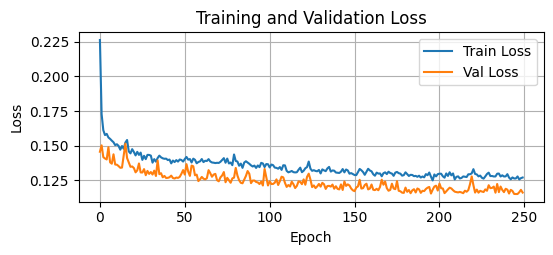

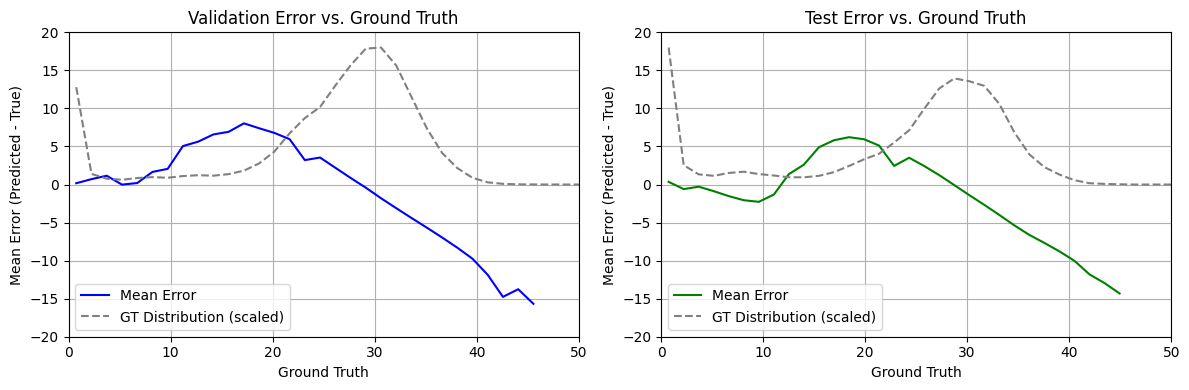

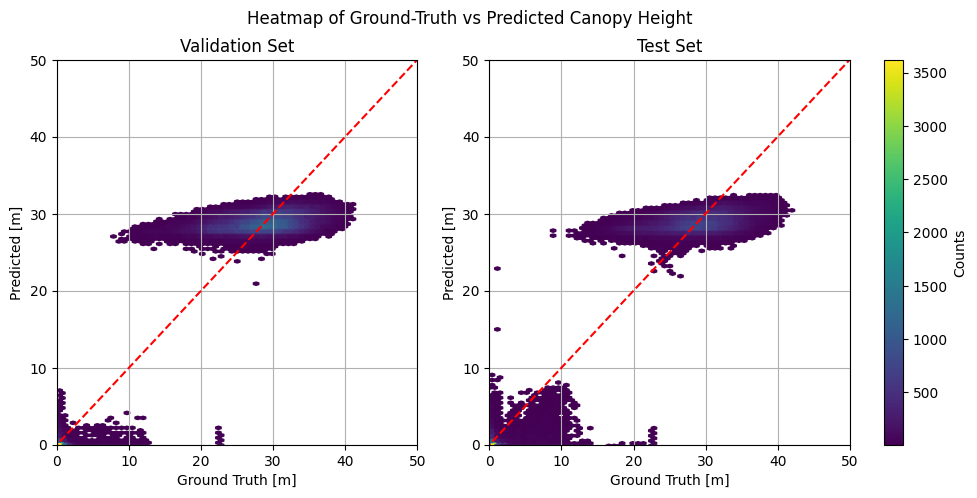

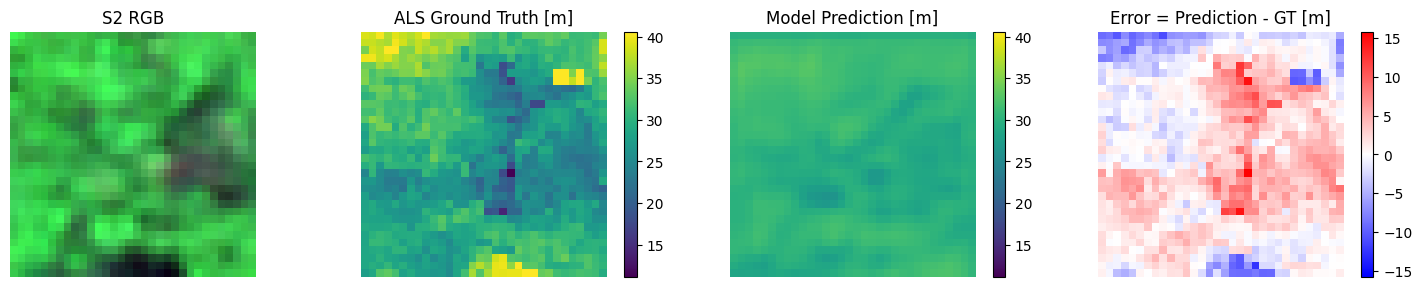

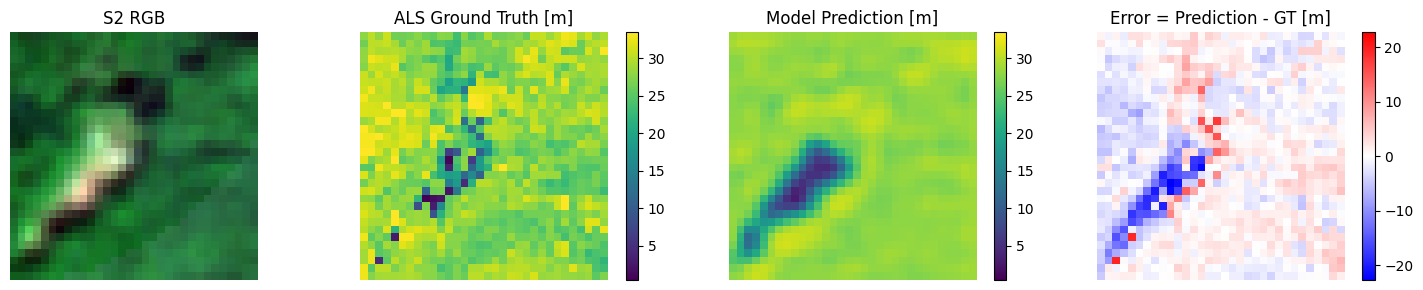

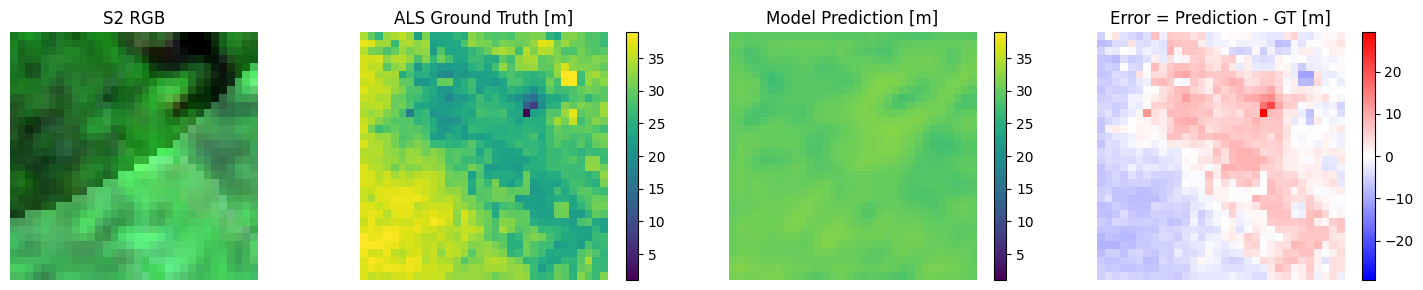

Configuration Parameters:
patch_size: 	32
num_bands: 	15
batch_size: 	64
lr: 		1.58e-03
weight_decay: 	0.00011857932779501748
momentum: 	0.8592091247827313
epochs: 	250
huber_delta: 	0.2
device: 	mps
edge_weight: 	1.001358142144912
max_weight: 	9.518803204299276
-------------------------------
Model size: 		7.13 MB 
Number of parameters: 	1.87e+06
-------------------------------
Evaluation report completed.


In [60]:
eval.plot_eval_report(train_losses, val_losses, model, val_loader,test_loader, json_path=ALS_NORM_PARAMS_JOINT, config=config)

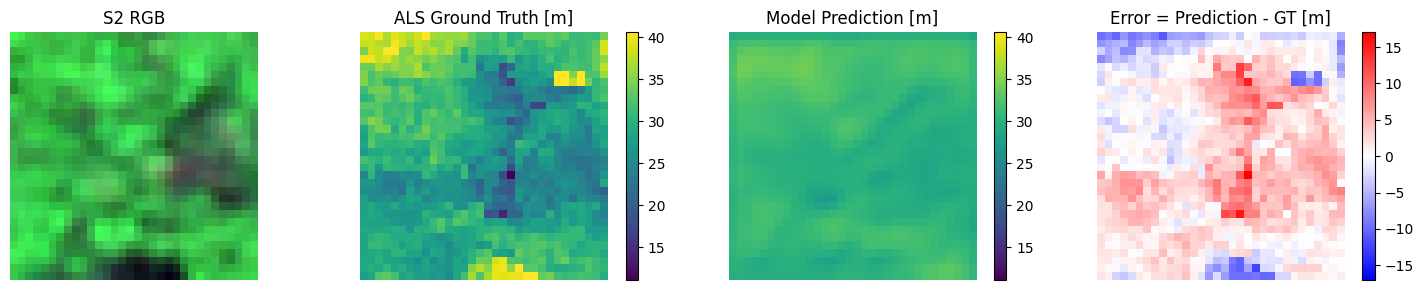

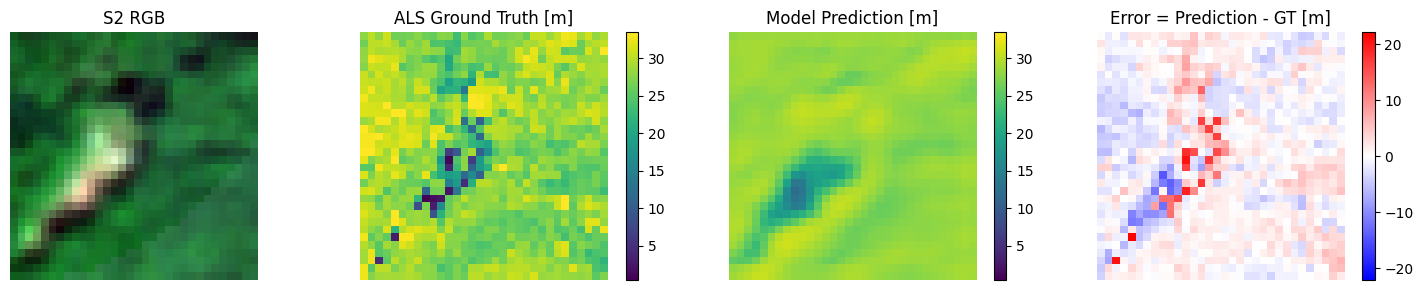

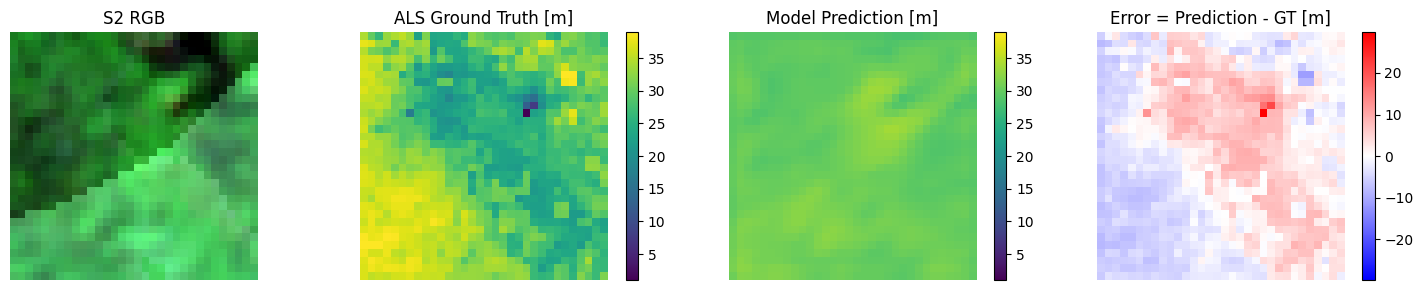

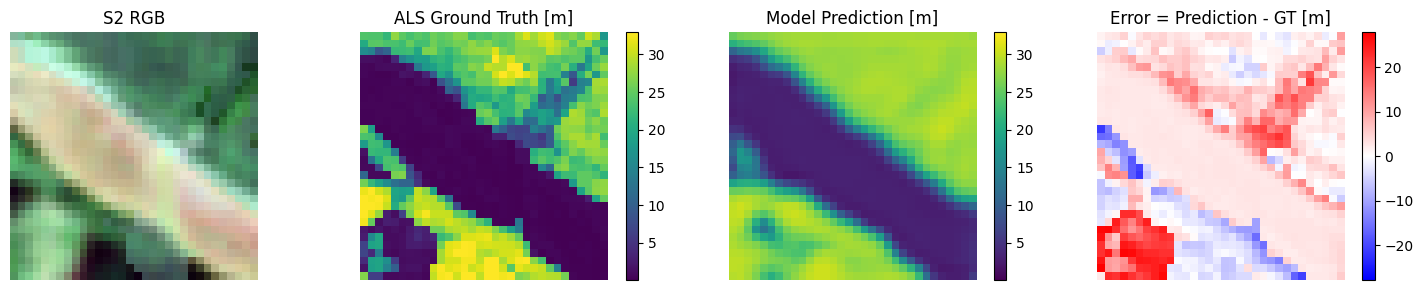

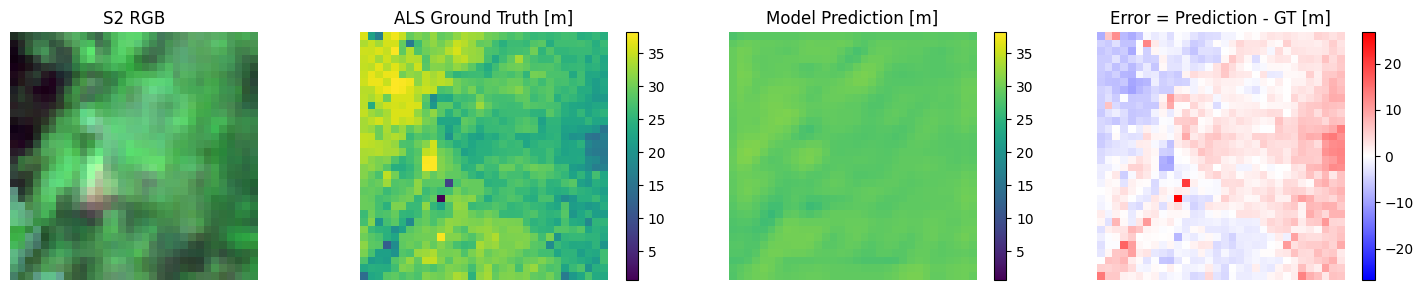

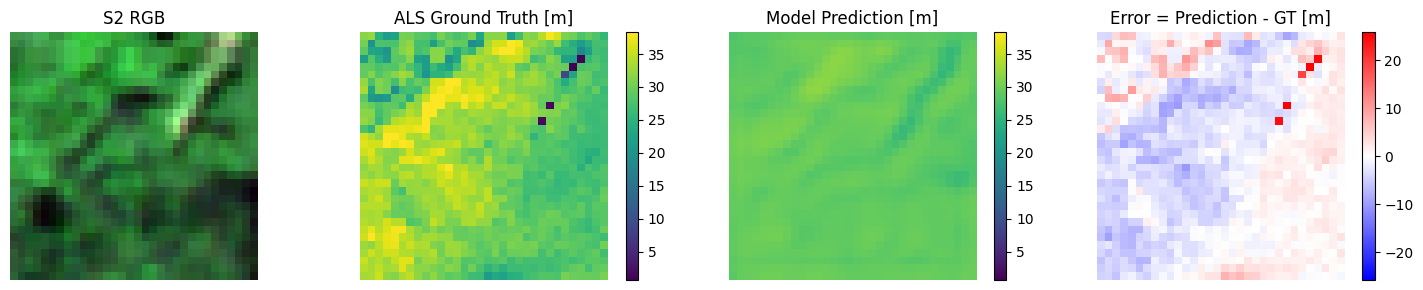

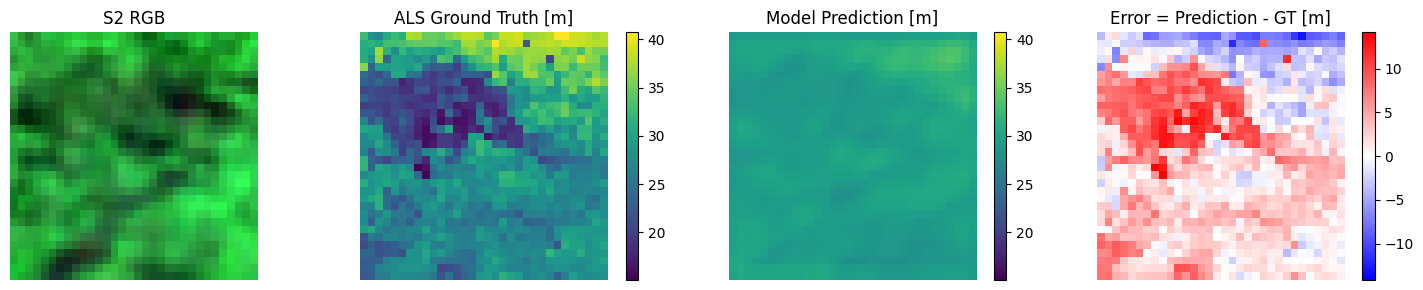

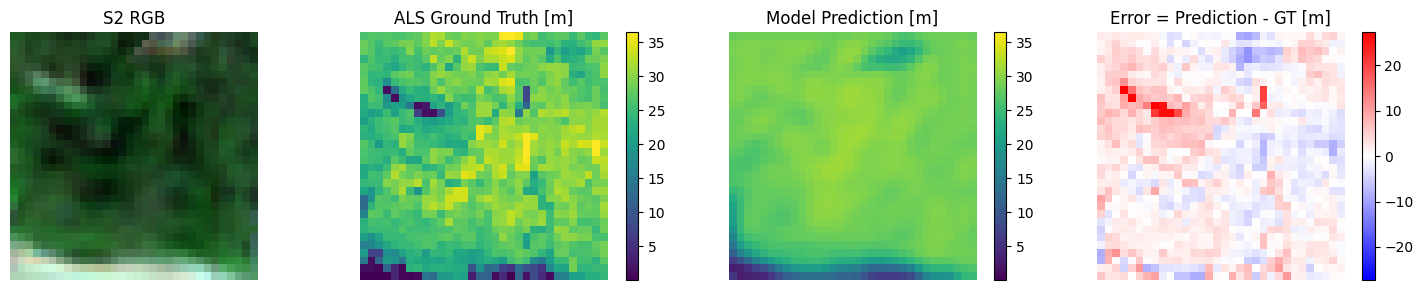

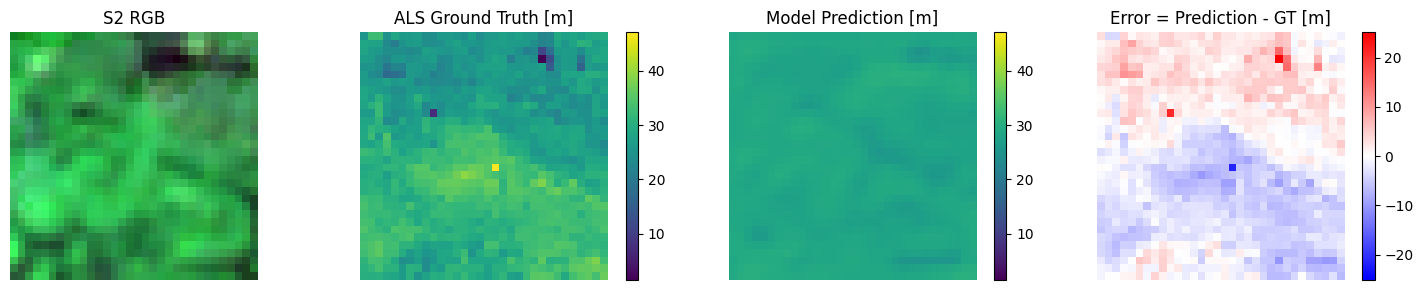

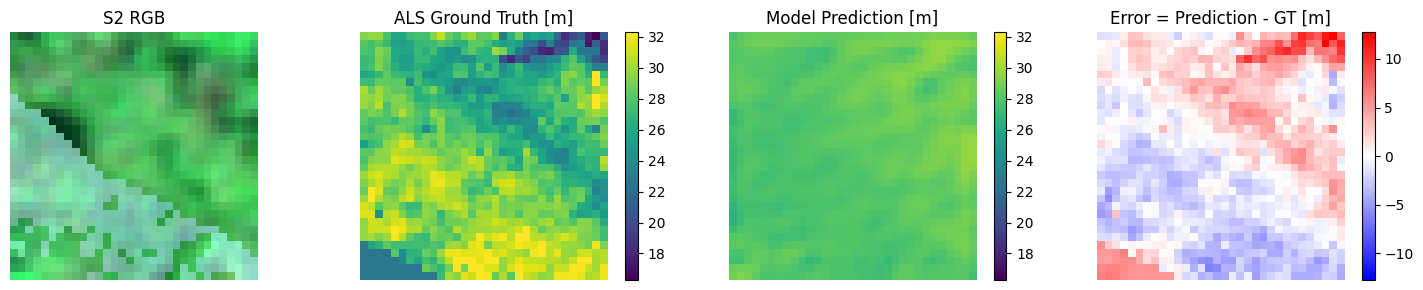

In [27]:
eval.plot_real_pred_delta(model, val_loader, num_samples=10, device=config['device'],json_path=ALS_NORM_PARAMS_JOINT)

## Frequency based reweighting

### frequency based reweighting

### tuna search

In [60]:
#print count where mask is zero in the validation set
val_mask_zero_count = 0
for inputs, targets, mask in train_loader:
    mask = mask.to(config['device'])
    val_mask_zero_count += (mask == False).sum().item()
print(f"Validation mask zero count: {val_mask_zero_count}")

Validation mask zero count: 2435


In [26]:
import optuna
def objective(trial):
    # Suggest hyperparameters
    batch_size = trial.suggest_categorical('batch_size', [64])
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    momentum = trial.suggest_float('momentum', 0.6, 0.99)
    huber_delta = trial.suggest_float('huber_delta', 0.6, 0.6)
    max_weight = trial.suggest_float('max_weight', 5.0, 35.0)
    tail_factor = trial.suggest_float('tail_factor', 1.0, 1.5)
    #edge_weight = trial.suggest_float('edge_weight', 1.0, 3.0)

    # Update config
    config.update({
        'batch_size': batch_size,
        'lr': lr,
        'weight_decay': weight_decay,
        'momentum': momentum,
        'huber_delta': huber_delta,
        'max_weight': max_weight,
        'tail_factor': tail_factor
        #'edge_weight': edge_weight
    })

    # Re-create loaders with new batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    hist, bin_edges = train_dataset.__getdistr__()

    # Model, optimizer, loss
    model = UNet(config['num_bands']).to(config['device'])
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = frequency_weighted_huber_loss

    # Training loop (short for tuning)
    epochs = 30
    for epoch in range(epochs):
        model.train()
        for inputs, targets, mask in train_loader:
            inputs, targets, mask = inputs.to(config['device']), targets.to(config['device']), mask.to(config['device'])
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets, mask, delta=huber_delta, hist=hist, bin_edges=bin_edges, max_weight=max_weight, tail_factor=tail_factor)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets, mask in val_loader:
                inputs, targets, mask = inputs.to(config['device']), targets.to(config['device']), mask.to(config['device'])
                outputs = model(inputs)
                loss = criterion(outputs, targets, mask, delta=huber_delta, hist=hist, bin_edges=bin_edges,max_weight=max_weight, tail_factor=tail_factor)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)

        # calculate a weighted mean absolute error based on the histogram of the training set
        hist, bin_edges = train_dataset.__getdistr__()
        bin_indices = np.digitize(targets.cpu().numpy(), bin_edges) - 1
        bin_indices = np.clip(bin_indices, 0, len(hist) - 1)
        freq = hist[bin_indices].astype(np.float32)
        freq = torch.from_numpy(freq).to(config['device']).float()
        weights = (1.0 / (freq + 1e-8)) ** 1
        weights = weights / weights.mean()
        weights = torch.clamp(weights, max=max_weight)
        weighted_mae = (torch.abs(outputs - targets) * weights).sum() / weights.sum().clamp(min=1)

        trial.report(weighted_mae, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return weighted_mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50,n_jobs=-1,show_progress_bar=True)

print("Best parameters:")
print(study.best_params)
print(f"Best validation loss: {study.best_value:.4f}")

# Overview of all trials
df_trials = study.trials_dataframe()
df_trials = df_trials.sort_values('value', ascending=True)
df_trials.head()

[I 2025-07-31 08:56:20,346] A new study created in memory with name: no-name-90aef9b8-eb10-447c-a421-5cc0c384c0cc
Best trial: 7. Best value: 1.85523:   2%|▏         | 1/50 [01:30<1:13:37, 90.16s/it]

[I 2025-07-31 08:57:50,485] Trial 7 finished with value: 1.8552252054214478 and parameters: {'batch_size': 64, 'lr': 0.0002883928294126474, 'weight_decay': 4.431731823455945e-05, 'momentum': 0.8611372835313635, 'huber_delta': 0.6, 'max_weight': 10.45042108309716, 'tail_factor': 1.1450486772486494}. Best is trial 7 with value: 1.8552252054214478.


Best trial: 7. Best value: 1.85523:   4%|▍         | 2/50 [01:40<34:29, 43.12s/it]  

[I 2025-07-31 08:58:00,697] Trial 11 finished with value: 2.888916015625 and parameters: {'batch_size': 64, 'lr': 0.009755993193234742, 'weight_decay': 1.714475162176644e-05, 'momentum': 0.7369518963180587, 'huber_delta': 0.6, 'max_weight': 22.68416258997038, 'tail_factor': 1.2787967832850136}. Best is trial 7 with value: 1.8552252054214478.


Best trial: 7. Best value: 1.85523:   6%|▌         | 3/50 [01:53<23:12, 29.63s/it]

[I 2025-07-31 08:58:14,260] Trial 4 finished with value: 2.447272539138794 and parameters: {'batch_size': 64, 'lr': 0.00048398327717645833, 'weight_decay': 0.0009458846717534557, 'momentum': 0.6223469154953125, 'huber_delta': 0.6, 'max_weight': 32.01471965632085, 'tail_factor': 1.1440603496524482}. Best is trial 7 with value: 1.8552252054214478.


Best trial: 7. Best value: 1.85523:   8%|▊         | 4/50 [02:17<20:47, 27.11s/it]

[I 2025-07-31 08:58:37,518] Trial 8 finished with value: 2.6977427005767822 and parameters: {'batch_size': 64, 'lr': 0.006606046443443759, 'weight_decay': 1.48908038655478e-05, 'momentum': 0.7880818148011518, 'huber_delta': 0.6, 'max_weight': 30.208391287441454, 'tail_factor': 1.07041280014489}. Best is trial 7 with value: 1.8552252054214478.


Best trial: 7. Best value: 1.85523:  10%|█         | 5/50 [02:41<19:41, 26.26s/it]

[I 2025-07-31 08:59:02,262] Trial 3 finished with value: 2.4061026573181152 and parameters: {'batch_size': 64, 'lr': 0.00032191329060388244, 'weight_decay': 6.919492506596121e-05, 'momentum': 0.6620651463221906, 'huber_delta': 0.6, 'max_weight': 24.198773692928313, 'tail_factor': 1.309869889650746}. Best is trial 7 with value: 1.8552252054214478.


Best trial: 7. Best value: 1.85523:  12%|█▏        | 6/50 [02:44<13:25, 18.30s/it]

[I 2025-07-31 08:59:05,111] Trial 15 pruned. 


Best trial: 12. Best value: 1.55195:  16%|█▌        | 8/50 [03:12<10:11, 14.57s/it]

[I 2025-07-31 08:59:32,584] Trial 12 finished with value: 1.5519508123397827 and parameters: {'batch_size': 64, 'lr': 0.0014902787980948708, 'weight_decay': 0.00011959000547292482, 'momentum': 0.8820253250187461, 'huber_delta': 0.6, 'max_weight': 6.01417965815193, 'tail_factor': 1.015024500828315}. Best is trial 12 with value: 1.5519508123397827.
[I 2025-07-31 08:59:32,739] Trial 1 pruned. 


Best trial: 12. Best value: 1.55195:  18%|█▊        | 9/50 [03:15<07:36, 11.13s/it]

[I 2025-07-31 08:59:36,318] Trial 18 pruned. 


Best trial: 12. Best value: 1.55195:  20%|██        | 10/50 [03:19<05:53,  8.83s/it]

[I 2025-07-31 08:59:39,997] Trial 20 pruned. 


Best trial: 12. Best value: 1.55195:  22%|██▏       | 11/50 [03:20<04:13,  6.51s/it]

[I 2025-07-31 08:59:41,240] Trial 19 pruned. 


Best trial: 12. Best value: 1.55195:  24%|██▍       | 12/50 [03:24<03:32,  5.59s/it]

[I 2025-07-31 08:59:44,736] Trial 13 finished with value: 2.2370805740356445 and parameters: {'batch_size': 64, 'lr': 0.00011270030922722027, 'weight_decay': 0.00013117355457486856, 'momentum': 0.8073525956276153, 'huber_delta': 0.6, 'max_weight': 16.141596697579885, 'tail_factor': 1.454493825857003}. Best is trial 12 with value: 1.5519508123397827.


Best trial: 12. Best value: 1.55195:  26%|██▌       | 13/50 [03:38<05:06,  8.29s/it]

[I 2025-07-31 08:59:59,219] Trial 14 finished with value: 2.168933629989624 and parameters: {'batch_size': 64, 'lr': 0.00061011983104234, 'weight_decay': 0.0022415397000028706, 'momentum': 0.9763009532527468, 'huber_delta': 0.6, 'max_weight': 17.10231220127155, 'tail_factor': 1.1625262645846532}. Best is trial 12 with value: 1.5519508123397827.


Best trial: 12. Best value: 1.55195:  28%|██▊       | 14/50 [03:43<04:18,  7.19s/it]

[I 2025-07-31 09:00:03,876] Trial 2 pruned. 


Best trial: 12. Best value: 1.55195:  30%|███       | 15/50 [04:08<07:18, 12.54s/it]

[I 2025-07-31 09:00:28,808] Trial 10 finished with value: 1.9181339740753174 and parameters: {'batch_size': 64, 'lr': 0.00019835448220743515, 'weight_decay': 0.001891165428743067, 'momentum': 0.8448069531841218, 'huber_delta': 0.6, 'max_weight': 7.463711417783855, 'tail_factor': 1.40031032764598}. Best is trial 12 with value: 1.5519508123397827.


Best trial: 12. Best value: 1.55195:  32%|███▏      | 16/50 [04:21<07:12, 12.72s/it]

[I 2025-07-31 09:00:41,965] Trial 6 pruned. 


Best trial: 12. Best value: 1.55195:  34%|███▍      | 17/50 [04:35<07:13, 13.14s/it]

[I 2025-07-31 09:00:56,063] Trial 17 finished with value: 2.2242980003356934 and parameters: {'batch_size': 64, 'lr': 0.00030275434426085617, 'weight_decay': 0.0013538198373056183, 'momentum': 0.9423704567148709, 'huber_delta': 0.6, 'max_weight': 16.314575576228293, 'tail_factor': 1.3495052909025425}. Best is trial 12 with value: 1.5519508123397827.


Best trial: 12. Best value: 1.55195:  36%|███▌      | 18/50 [04:39<05:34, 10.44s/it]

[I 2025-07-31 09:01:00,218] Trial 16 finished with value: 1.7082288265228271 and parameters: {'batch_size': 64, 'lr': 0.0003145666255133932, 'weight_decay': 0.0020409095572944584, 'momentum': 0.868462848949359, 'huber_delta': 0.6, 'max_weight': 7.668941541132383, 'tail_factor': 1.1628035242960078}. Best is trial 12 with value: 1.5519508123397827.


Best trial: 12. Best value: 1.55195:  38%|███▊      | 19/50 [04:45<04:37,  8.95s/it]

[I 2025-07-31 09:01:05,691] Trial 0 pruned. 


Best trial: 12. Best value: 1.55195:  40%|████      | 20/50 [05:08<06:35, 13.18s/it]

[I 2025-07-31 09:01:28,724] Trial 21 finished with value: 1.717637062072754 and parameters: {'batch_size': 64, 'lr': 0.0018770878821293081, 'weight_decay': 0.0005735473018936808, 'momentum': 0.9808792751131703, 'huber_delta': 0.6, 'max_weight': 8.28203771454345, 'tail_factor': 1.0113733314112832}. Best is trial 12 with value: 1.5519508123397827.


Best trial: 12. Best value: 1.55195:  42%|████▏     | 21/50 [05:13<05:08, 10.65s/it]

[I 2025-07-31 09:01:33,501] Trial 23 finished with value: 1.7071999311447144 and parameters: {'batch_size': 64, 'lr': 0.001872506324749363, 'weight_decay': 4.904648370414395e-05, 'momentum': 0.8933677342007396, 'huber_delta': 0.6, 'max_weight': 6.574575568441104, 'tail_factor': 1.0077920341146662}. Best is trial 12 with value: 1.5519508123397827.


Best trial: 12. Best value: 1.55195:  44%|████▍     | 22/50 [05:28<05:34, 11.94s/it]

[I 2025-07-31 09:01:48,429] Trial 24 finished with value: 1.5916566848754883 and parameters: {'batch_size': 64, 'lr': 0.0015056891809236354, 'weight_decay': 3.6004609862811486e-05, 'momentum': 0.9033567830809801, 'huber_delta': 0.6, 'max_weight': 6.182716282871615, 'tail_factor': 1.0231178496689557}. Best is trial 12 with value: 1.5519508123397827.


Best trial: 12. Best value: 1.55195:  46%|████▌     | 23/50 [05:30<04:02,  8.98s/it]

[I 2025-07-31 09:01:50,525] Trial 22 finished with value: 1.5521223545074463 and parameters: {'batch_size': 64, 'lr': 0.0018389892615915517, 'weight_decay': 5.142151152562738e-05, 'momentum': 0.8976693263534644, 'huber_delta': 0.6, 'max_weight': 6.044448657116393, 'tail_factor': 1.0015317544149405}. Best is trial 12 with value: 1.5519508123397827.


Best trial: 12. Best value: 1.55195:  48%|████▊     | 24/50 [05:30<02:47,  6.45s/it]

[I 2025-07-31 09:01:51,080] Trial 9 pruned. 


Best trial: 12. Best value: 1.55195:  50%|█████     | 25/50 [05:52<04:32, 10.91s/it]

[I 2025-07-31 09:02:12,393] Trial 34 pruned. 


Best trial: 28. Best value: 1.53117:  52%|█████▏    | 26/50 [06:29<07:33, 18.88s/it]

[I 2025-07-31 09:02:49,870] Trial 28 finished with value: 1.5311717987060547 and parameters: {'batch_size': 64, 'lr': 0.0021142948306581873, 'weight_decay': 0.0005339162061687784, 'momentum': 0.8815819031913302, 'huber_delta': 0.6, 'max_weight': 5.23738042451487, 'tail_factor': 1.0032793851581325}. Best is trial 28 with value: 1.5311717987060547.


Best trial: 28. Best value: 1.53117:  54%|█████▍    | 27/50 [06:37<05:55, 15.47s/it]

[I 2025-07-31 09:02:57,369] Trial 26 finished with value: 1.5334045886993408 and parameters: {'batch_size': 64, 'lr': 0.001901936818877846, 'weight_decay': 4.7423325101679494e-05, 'momentum': 0.9059744605607108, 'huber_delta': 0.6, 'max_weight': 5.015451503697784, 'tail_factor': 1.000594842510534}. Best is trial 28 with value: 1.5311717987060547.


Best trial: 28. Best value: 1.53117:  56%|█████▌    | 28/50 [06:41<04:25, 12.05s/it]

[I 2025-07-31 09:03:01,440] Trial 29 finished with value: 1.5759012699127197 and parameters: {'batch_size': 64, 'lr': 0.0020005251021129678, 'weight_decay': 0.0007424554944382132, 'momentum': 0.9094992706200862, 'huber_delta': 0.6, 'max_weight': 5.284890850941081, 'tail_factor': 1.0308466002994923}. Best is trial 28 with value: 1.5311717987060547.


Best trial: 28. Best value: 1.53117:  58%|█████▊    | 29/50 [06:42<03:04,  8.80s/it]

[I 2025-07-31 09:03:02,664] Trial 38 pruned. 


Best trial: 28. Best value: 1.53117:  60%|██████    | 30/50 [06:49<02:46,  8.30s/it]

[I 2025-07-31 09:03:09,808] Trial 39 pruned. 


Best trial: 28. Best value: 1.53117:  62%|██████▏   | 31/50 [06:53<02:15,  7.11s/it]

[I 2025-07-31 09:03:14,128] Trial 41 pruned. 


Best trial: 28. Best value: 1.53117:  64%|██████▍   | 32/50 [06:57<01:51,  6.19s/it]

[I 2025-07-31 09:03:18,188] Trial 40 pruned. 


Best trial: 31. Best value: 1.50354:  66%|██████▌   | 33/50 [06:58<01:18,  4.62s/it]

[I 2025-07-31 09:03:19,134] Trial 31 finished with value: 1.5035427808761597 and parameters: {'batch_size': 64, 'lr': 0.0015488331678234905, 'weight_decay': 0.000461641527366346, 'momentum': 0.8984920812305571, 'huber_delta': 0.6, 'max_weight': 5.185012803096109, 'tail_factor': 1.0211981446815714}. Best is trial 31 with value: 1.5035427808761597.


Best trial: 31. Best value: 1.50354:  68%|██████▊   | 34/50 [07:04<01:16,  4.80s/it]

[I 2025-07-31 09:03:24,356] Trial 32 finished with value: 1.5127195119857788 and parameters: {'batch_size': 64, 'lr': 0.0015952332523124363, 'weight_decay': 0.0004519818194030247, 'momentum': 0.9044064907586072, 'huber_delta': 0.6, 'max_weight': 5.112741793286851, 'tail_factor': 1.0022170641502317}. Best is trial 31 with value: 1.5035427808761597.


Best trial: 31. Best value: 1.50354:  70%|███████   | 35/50 [07:06<01:01,  4.10s/it]

[I 2025-07-31 09:03:26,825] Trial 42 pruned. 


Best trial: 31. Best value: 1.50354:  72%|███████▏  | 36/50 [07:07<00:45,  3.25s/it]

[I 2025-07-31 09:03:28,098] Trial 45 pruned. 


Best trial: 31. Best value: 1.50354:  74%|███████▍  | 37/50 [07:12<00:49,  3.82s/it]

[I 2025-07-31 09:03:33,228] Trial 43 pruned. 


Best trial: 31. Best value: 1.50354:  76%|███████▌  | 38/50 [07:13<00:35,  2.97s/it]

[I 2025-07-31 09:03:34,236] Trial 44 pruned. 


Best trial: 31. Best value: 1.50354:  78%|███████▊  | 39/50 [07:17<00:35,  3.23s/it]

[I 2025-07-31 09:03:38,059] Trial 48 pruned. 
[I 2025-07-31 09:03:38,120] Trial 49 pruned. 


Best trial: 33. Best value: 1.48583:  82%|████████▏ | 41/50 [07:19<00:20,  2.27s/it]

[I 2025-07-31 09:03:40,344] Trial 33 finished with value: 1.4858287572860718 and parameters: {'batch_size': 64, 'lr': 0.0015540615839910214, 'weight_decay': 7.808637092038728e-05, 'momentum': 0.9052841049820021, 'huber_delta': 0.6, 'max_weight': 5.288281459846844, 'tail_factor': 1.0065604365467697}. Best is trial 33 with value: 1.4858287572860718.


Best trial: 33. Best value: 1.48583:  84%|████████▍ | 42/50 [07:20<00:14,  1.84s/it]

[I 2025-07-31 09:03:40,885] Trial 5 pruned. 


Best trial: 33. Best value: 1.48583:  86%|████████▌ | 43/50 [07:22<00:12,  1.84s/it]

[I 2025-07-31 09:03:42,734] Trial 46 pruned. 


Best trial: 33. Best value: 1.48583:  88%|████████▊ | 44/50 [07:22<00:08,  1.45s/it]

[I 2025-07-31 09:03:43,125] Trial 47 pruned. 


Best trial: 33. Best value: 1.48583:  90%|█████████ | 45/50 [07:45<00:37,  7.51s/it]

[I 2025-07-31 09:04:06,227] Trial 36 finished with value: 1.584635853767395 and parameters: {'batch_size': 64, 'lr': 0.0027277914195671057, 'weight_decay': 0.00037025954147587104, 'momentum': 0.9318746350375421, 'huber_delta': 0.6, 'max_weight': 5.237498116225235, 'tail_factor': 1.0950967876838587}. Best is trial 33 with value: 1.4858287572860718.


Best trial: 33. Best value: 1.48583:  92%|█████████▏| 46/50 [07:53<00:30,  7.61s/it]

[I 2025-07-31 09:04:14,103] Trial 25 finished with value: 1.5604954957962036 and parameters: {'batch_size': 64, 'lr': 0.0016700887402599958, 'weight_decay': 4.967035420629745e-05, 'momentum': 0.8862589818352526, 'huber_delta': 0.6, 'max_weight': 6.102062780021636, 'tail_factor': 1.0001449567761955}. Best is trial 33 with value: 1.4858287572860718.


Best trial: 33. Best value: 1.48583:  94%|█████████▍| 47/50 [08:00<00:21,  7.27s/it]

[I 2025-07-31 09:04:20,537] Trial 37 finished with value: 1.5442533493041992 and parameters: {'batch_size': 64, 'lr': 0.003387245051471726, 'weight_decay': 0.0003885241913476032, 'momentum': 0.9303439518099498, 'huber_delta': 0.6, 'max_weight': 5.128034331195786, 'tail_factor': 1.0955201793409595}. Best is trial 33 with value: 1.4858287572860718.


Best trial: 33. Best value: 1.48583:  96%|█████████▌| 48/50 [08:06<00:14,  7.10s/it]

[I 2025-07-31 09:04:27,236] Trial 35 finished with value: 1.6792384386062622 and parameters: {'batch_size': 64, 'lr': 0.0021530627068373754, 'weight_decay': 0.00010258373072421606, 'momentum': 0.914729939192655, 'huber_delta': 0.6, 'max_weight': 5.11046966093226, 'tail_factor': 1.0832840023896888}. Best is trial 33 with value: 1.4858287572860718.


Best trial: 33. Best value: 1.48583:  98%|█████████▊| 49/50 [08:08<00:05,  5.59s/it]

[I 2025-07-31 09:04:29,193] Trial 27 finished with value: 1.518367052078247 and parameters: {'batch_size': 64, 'lr': 0.0017969946663353538, 'weight_decay': 0.0004885498661272753, 'momentum': 0.9040645785205703, 'huber_delta': 0.6, 'max_weight': 5.0322763116185225, 'tail_factor': 1.0284813686936778}. Best is trial 33 with value: 1.4858287572860718.


Best trial: 33. Best value: 1.48583: 100%|██████████| 50/50 [08:11<00:00,  9.84s/it]

[I 2025-07-31 09:04:32,232] Trial 30 finished with value: 1.5382214784622192 and parameters: {'batch_size': 64, 'lr': 0.0017143729220577832, 'weight_decay': 0.0006460149938325584, 'momentum': 0.9024076418469249, 'huber_delta': 0.6, 'max_weight': 5.280622647752614, 'tail_factor': 1.0052878340549232}. Best is trial 33 with value: 1.4858287572860718.
Best parameters:
{'batch_size': 64, 'lr': 0.0015540615839910214, 'weight_decay': 7.808637092038728e-05, 'momentum': 0.9052841049820021, 'huber_delta': 0.6, 'max_weight': 5.288281459846844, 'tail_factor': 1.0065604365467697}
Best validation loss: 1.4858


,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_huber_delta,params_lr,params_max_weight,params_momentum,params_tail_factor,params_weight_decay,state
33,33,1.485829,2025-07-31 09:01:48.437497,2025-07-31 09:03:40.344820,0 days 00:01:51.907323,64,0.6,0.001554,5.288281,0.905284,1.006560,0.000078,COMPLETE
31,31,1.503543,2025-07-31 09:01:28.730341,2025-07-31 09:03:19.133917,0 days 00:01:50.403576,64,0.6,0.001549,5.185013,0.898492,1.021198,0.000462,COMPLETE
32,32,1.512720,2025-07-31 09:01:33.506267,2025-07-31 09:03:24.356414,0 days 00:01:50.850147,64,0.6,0.001595,5.112742,0.904406,1.002217,0.000452,COMPLETE
27,27,1.518367,2025-07-31 09:00:41.971413,2025-07-31 09:04:29.193162,0 days 00:03:47.221749,64,0.6,0.001797,5.032276,0.904065,1.028481,0.000489,COMPLETE
28,28,1.531172,2025-07-31 09:00:56.068908,2025-07-31 09:02:49.869794,0 days 00:01:53.800886,64,0.6,0.002114,5.237380,0.881582,1.003279,0.000534,COMPLETE


### regular training

In [61]:
# Central hyperparameter config
finetrainmode = False # not(pretrainmode)
config = {
    'patch_size': 32,
    'num_bands': 15,        # change based on input (13+1 for fmask, +1 for mask channel)
    'batch_size': 64,
    'lr': 1e-3,
    'weight_decay': 3e-4,
    'momentum': 0.9,
    'epochs': 400,
    'huber_delta': 1,
    'max_weight': 35.0,
    'tail_factor': 1.2,
    # 'edge_weight': 2.0,  # not used in final model
    'device':  'mps' if torch.backends.mps.is_available() else 'cpu'
}

#best_params = {'batch_size': 64, 'lr': 0.0011152887162198123, 'weight_decay': 0.0004652585119396249, 'momentum': 0.7992142651669868, 'huber_delta': 1} # 'max_weight': 3.681679702150505, 'tail_factor': 2.969084257537658}
#config.update(best_params)

config.update(study.best_params)

model = UNet(config['num_bands']).to(config['device']) 
# load pretrained model if available as initialization
optimizer = optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
hist, bin_edges = train_dataset.__getdistr__()


criterion_nomask = nn.HuberLoss(delta=config['huber_delta'])
criterion = frequency_weighted_huber_loss  # Use custom masked Huber loss
#criterion = masked_huber_loss
# criterion = nn.MSELoss()  # or nn.L1Loss() for Mean Absolute
# Learning rate scheduler
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)

train_losses, val_losses = [], []
nancounts = 0

for epoch in trange(config['epochs'], desc="Epochs"):
    model.train()
    train_loss = 0.0
    for inputs, targets, mask in train_loader:
        inputs, targets, mask = inputs.to(config['device']), targets.to(config['device']), mask.to(config['device'])
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets, mask, hist=hist,bin_edges=bin_edges, delta=config['huber_delta'], max_weight=config['max_weight'], tail_factor=config['tail_factor'])
        #loss = criterion(outputs, targets, mask)
        loss.backward()
        #loss_nomask = criterion_nomask(outputs,targets)
        #if abs(loss-loss_nomask)>1e-3: print("Error in Loss Function, unless nan input fed in.")
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        # Count number of zeros in the mask tensor for this batch
        nancounts += (mask == 0).sum().item()

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets, mask in val_loader:
            inputs, targets, mask = inputs.to(config['device']), targets.to(config['device']), mask.to(config['device'])
            outputs = model(inputs)
            
            loss = criterion(outputs, targets, mask, delta=config['huber_delta'], hist=hist,bin_edges=bin_edges,max_weight=config['max_weight'], tail_factor=config['tail_factor'])
            #loss = criterion(outputs, targets, mask)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if (epoch + 1) % 10 == 0 or epoch == config['epochs'] - 1:
        continue
        #print(f"Epoch {epoch+1}/{config['epochs']}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        #print(f"Epoch {epoch+1}/{config['epochs']}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    #print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
print("nancounts: ",nancounts)

Epochs: 100%|██████████| 400/400 [03:30<00:00,  1.90it/s]

nancounts:  974000


METRIC REPORT:
      Metric  Validation     Test
     MAE [m]        4.35     4.37
    RMSE [m]        5.50     5.47
    Bias [m]       -0.29    -0.13
      R2 [-]        0.68     0.77
 norm_mu [m]       28.35    28.35
norm_std [m]        5.72     5.72


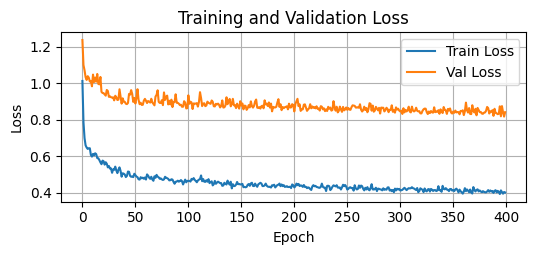

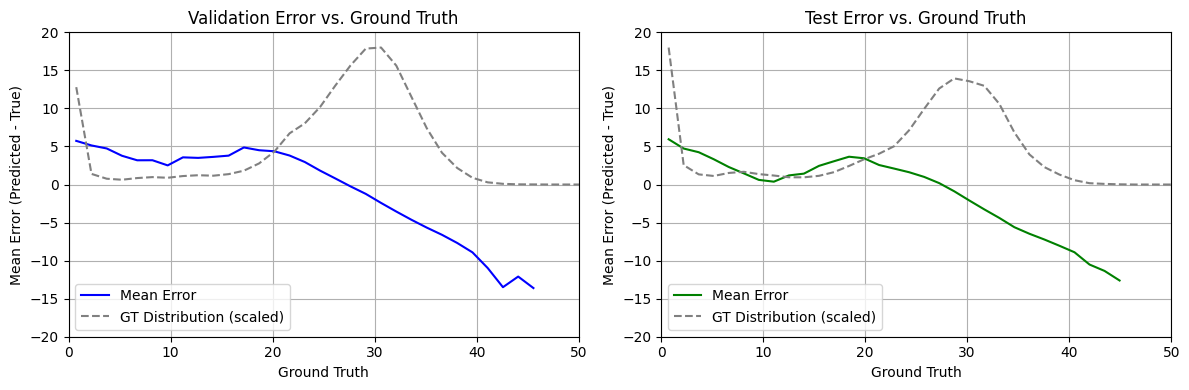

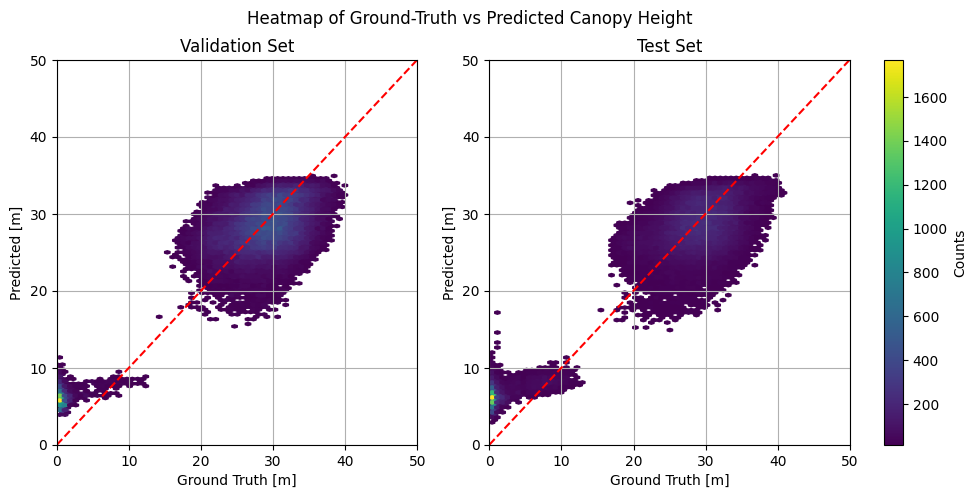

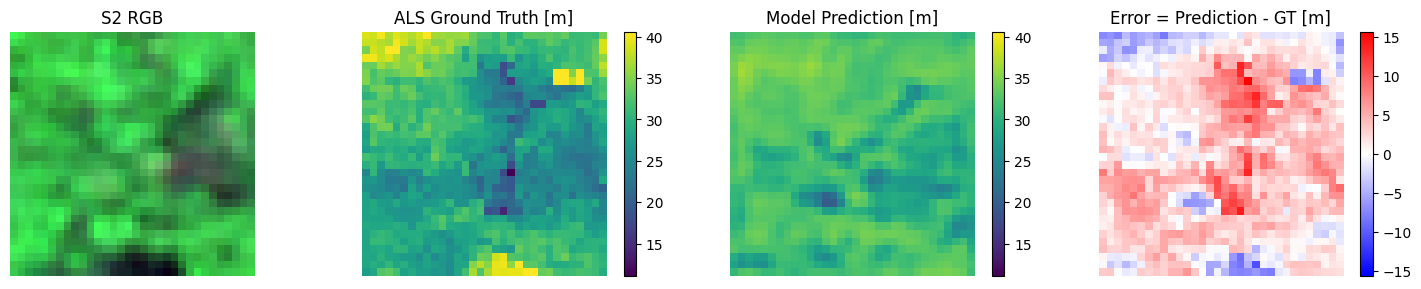

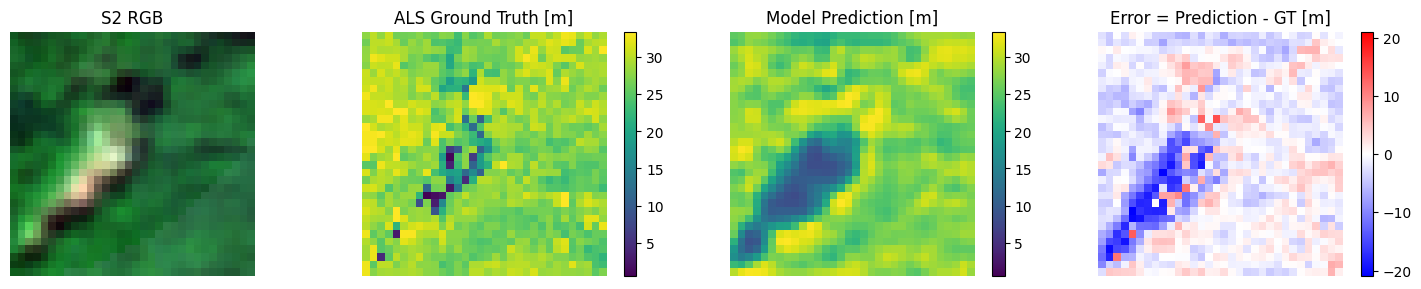

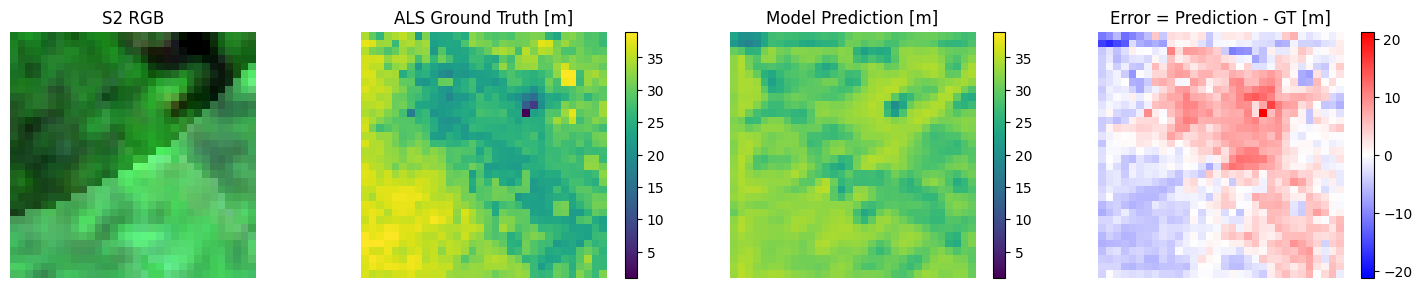

Configuration Parameters:
patch_size: 	32
num_bands: 	15
batch_size: 	64
lr: 		1.55e-03
weight_decay: 	7.808637092038728e-05
momentum: 	0.9052841049820021
epochs: 	400
huber_delta: 	0.6
max_weight: 	5.288281459846844
tail_factor: 	1.0065604365467697
device: 	mps
-------------------------------
Model size: 		7.13 MB 
Number of parameters: 	1.87e+06
-------------------------------
Evaluation report completed.


In [62]:
eval.plot_eval_report(train_losses, val_losses, model, val_loader, test_loader, json_path=ALS_NORM_PARAMS_JOINT, config=config)

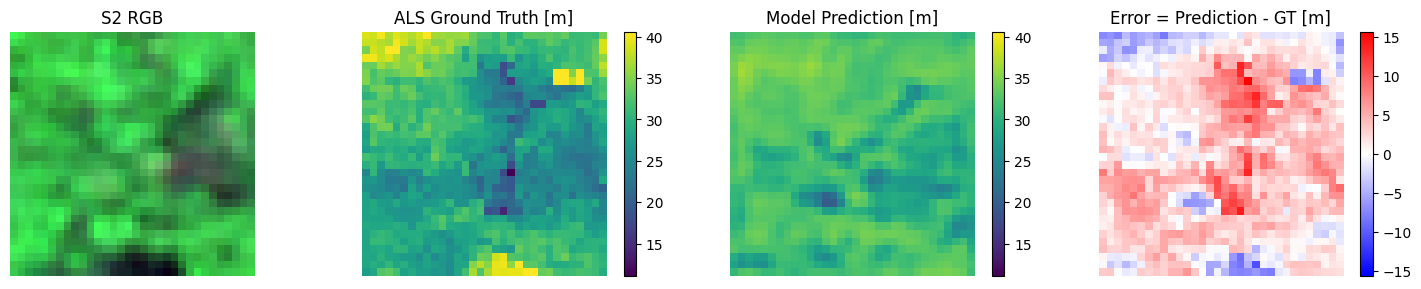

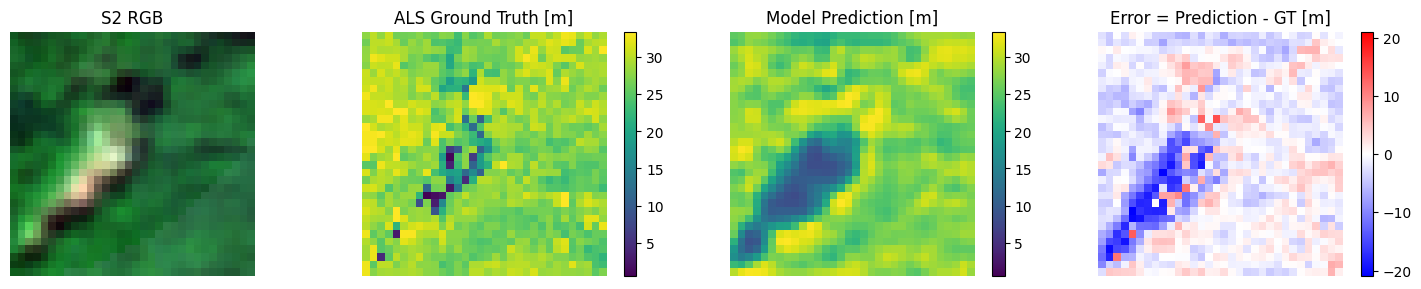

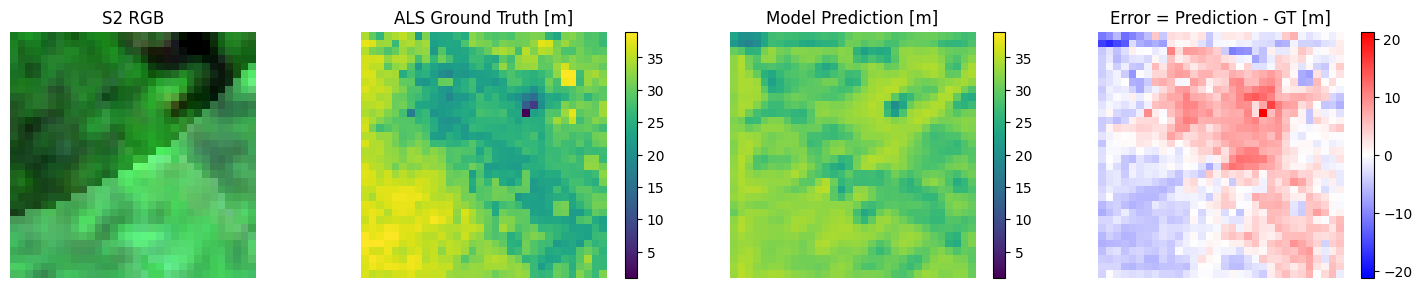

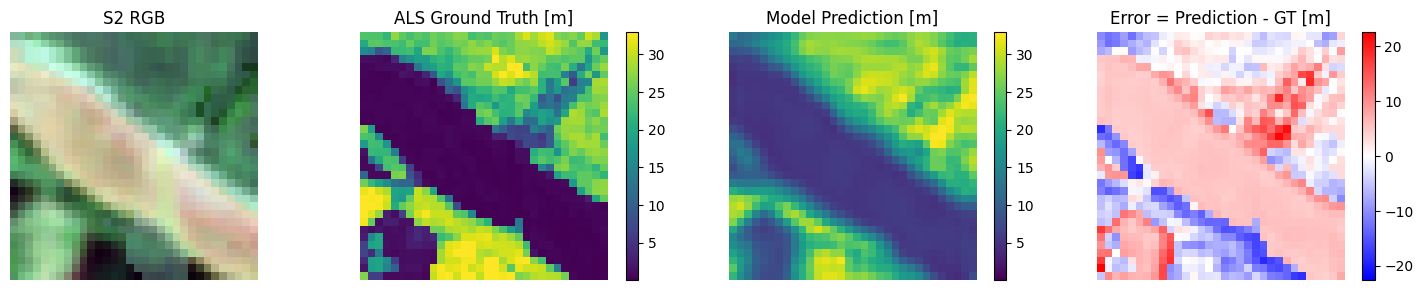

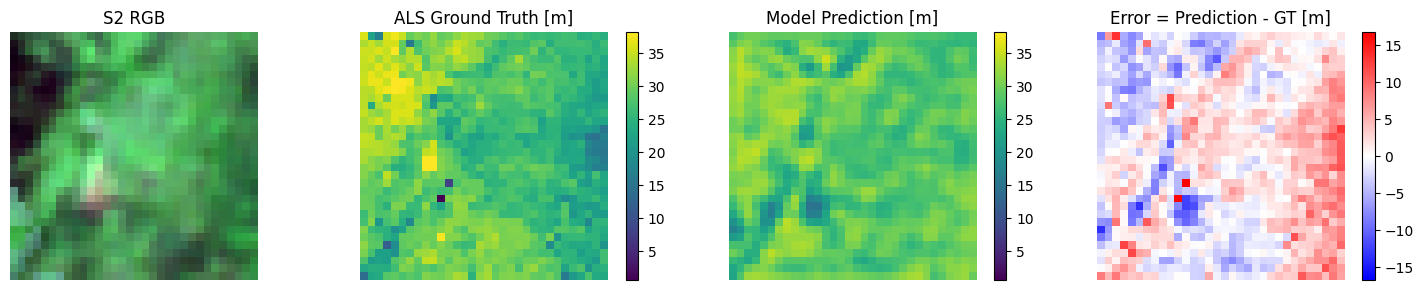

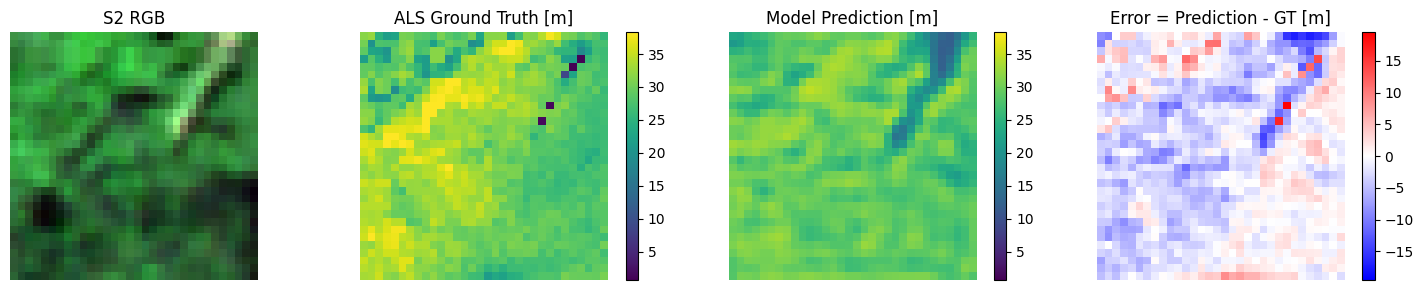

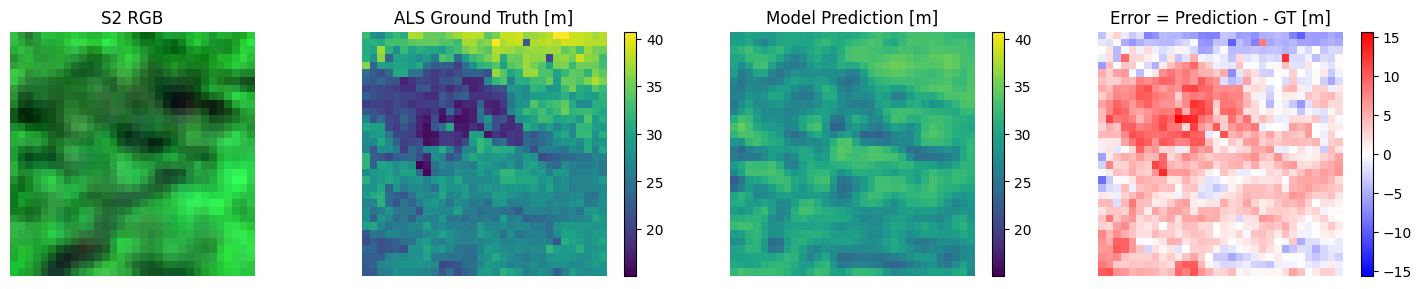

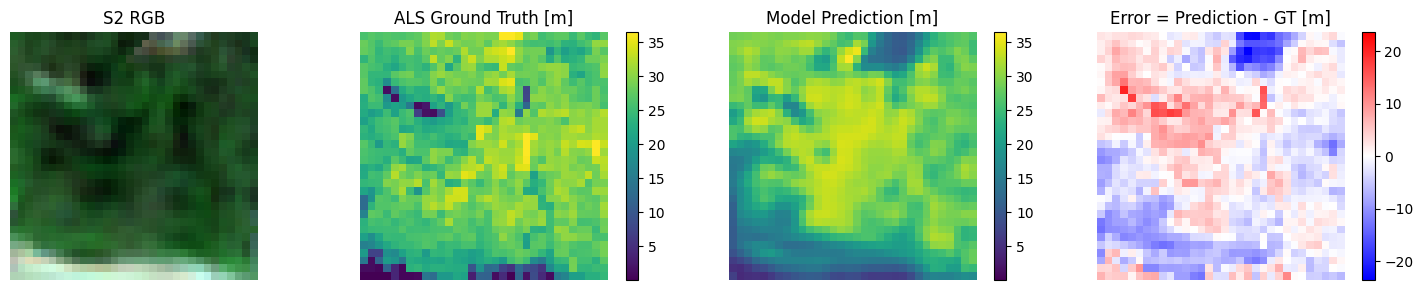

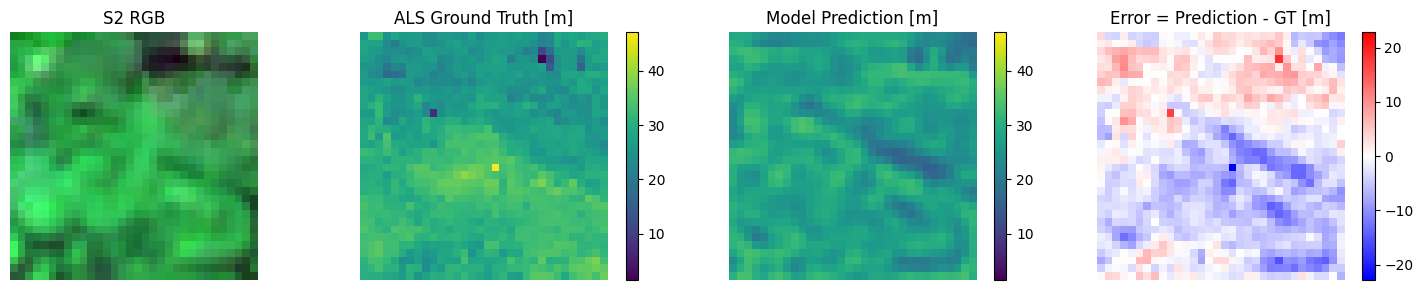

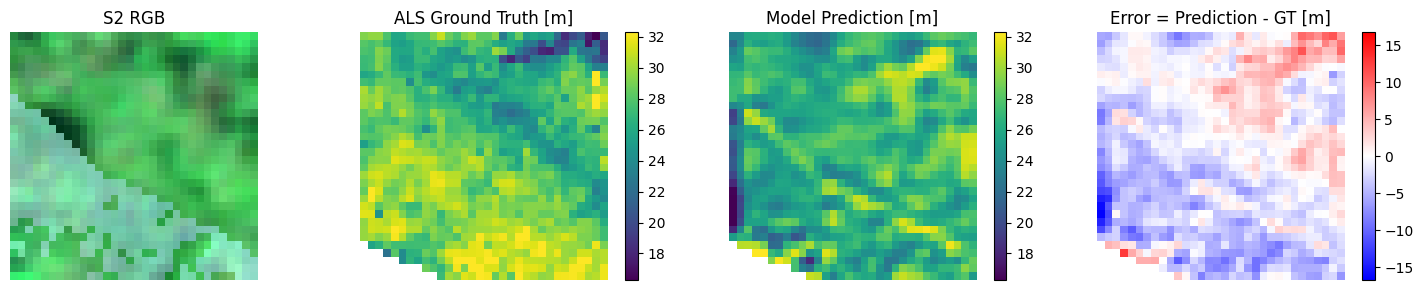

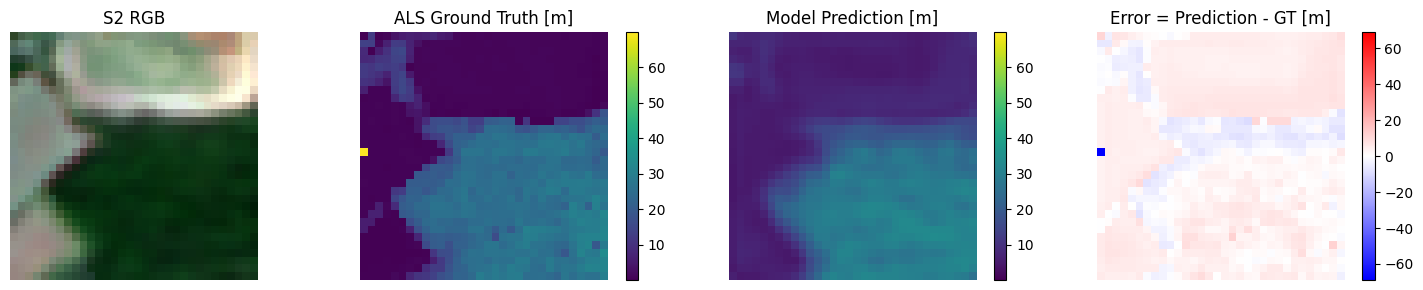

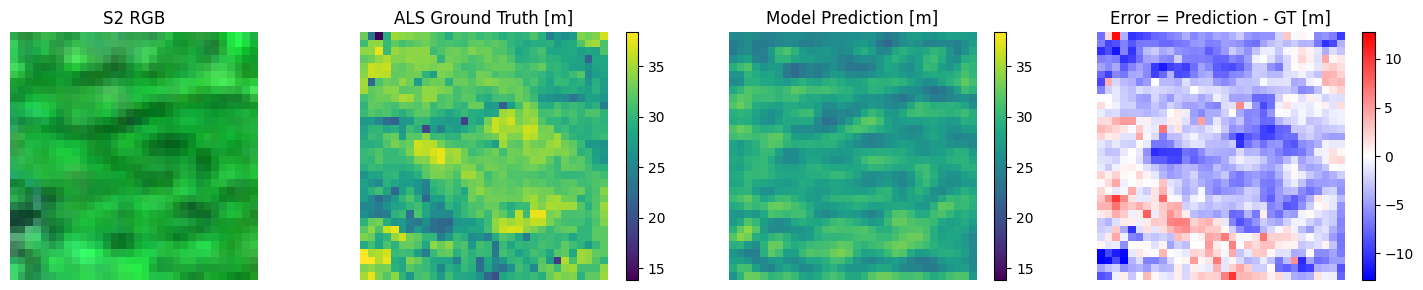

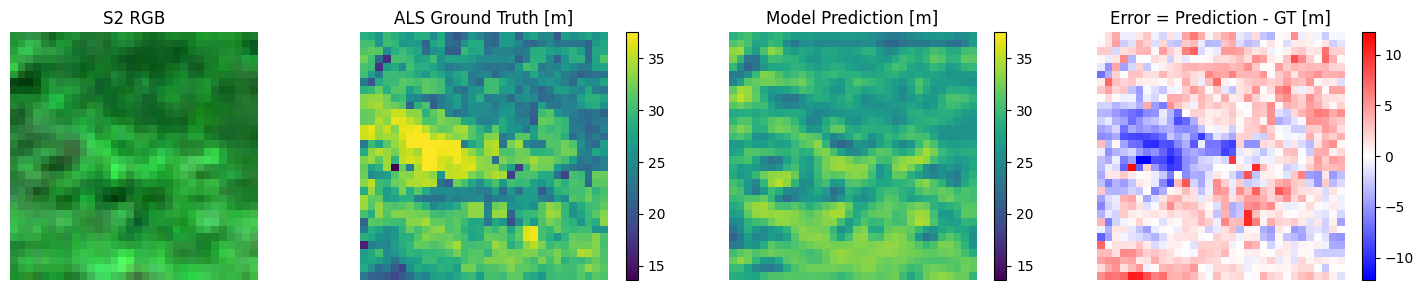

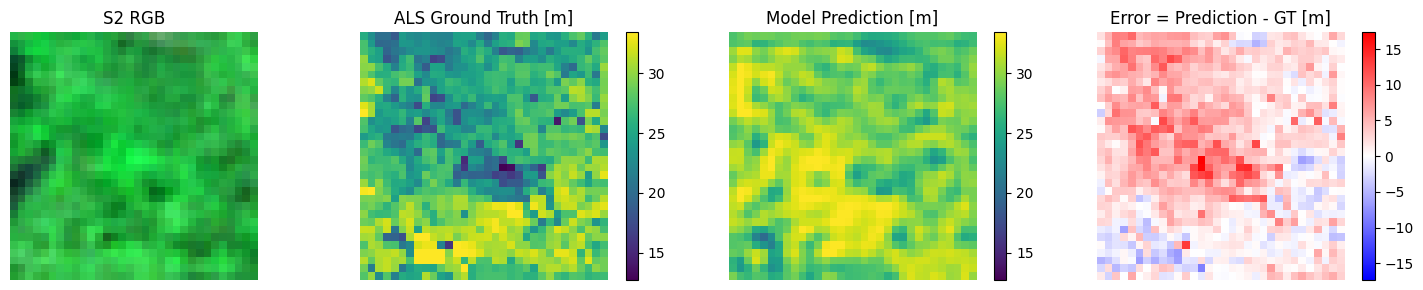

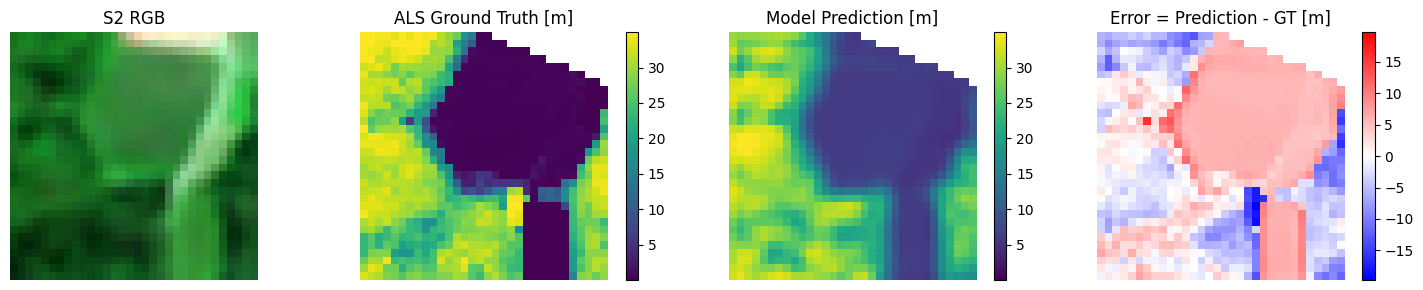

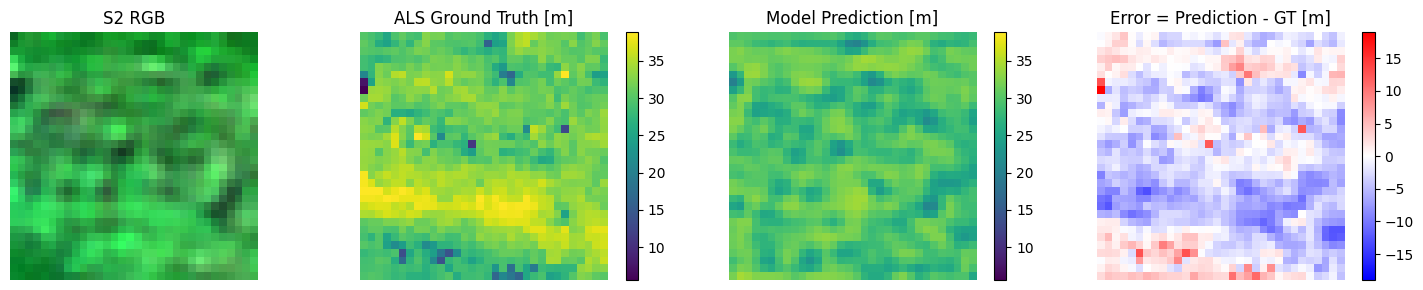

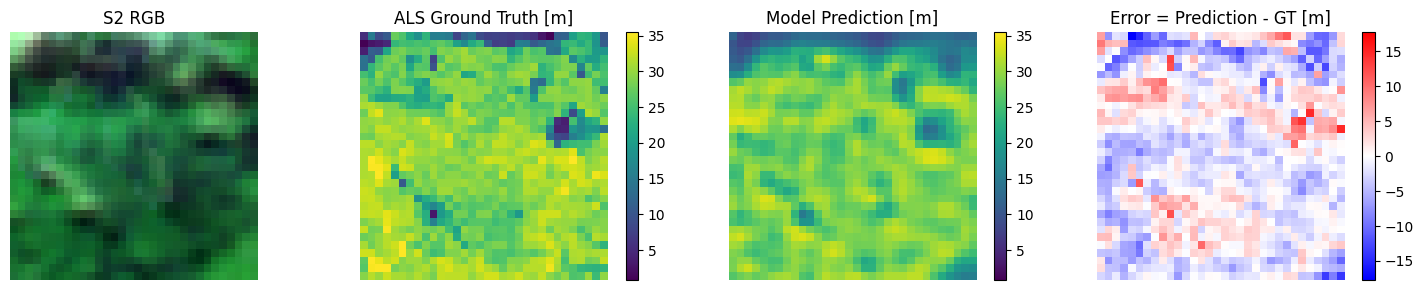

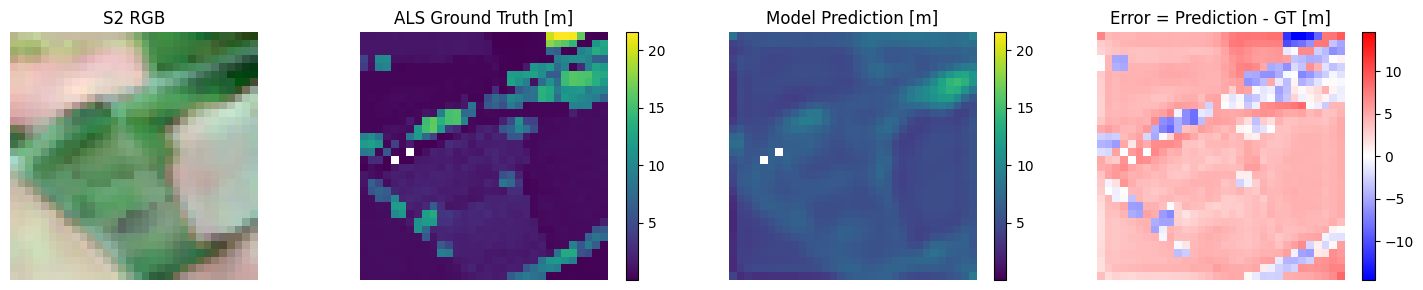

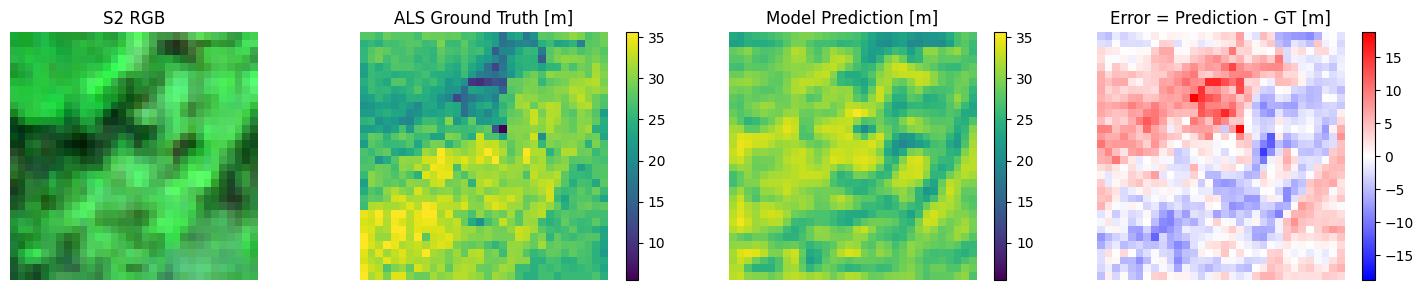

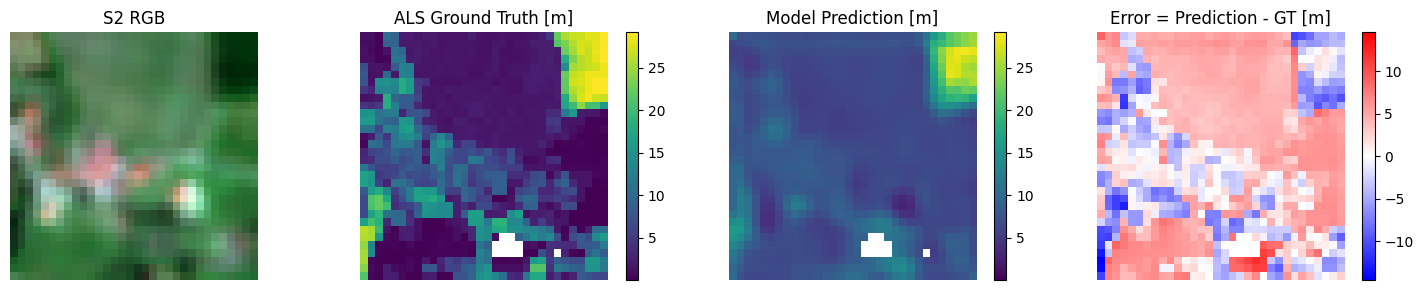

In [63]:
eval.plot_real_pred_delta(model, val_loader, num_samples=20, device=config['device'],json_path=ALS_NORM_PARAMS_JOINT)

### further ideas

weitere Ideen:
- train 1st site
- use weights as init, train with 2nd site 
- test with 2nd site 
--> if this retraining significantly improves performance, then data amount is bottleneck

---

- dropout parameter experiments 
- ML Perceptron mit mittlerem Pixel vergleichen

- Layer von sentinel auf verschiedenen ebenen des U-Nets einbringen (?)
- DEM als zusätzliche Input Layer (Sri has DEM)
---
Loss-Function engineering:
- frequency-based-reweighting
- **edge sensitive loss**
---
Learning of middle-features before learning CHM
- Forest(Y/N): U-Net + classification for ForestMask (cross-entropy-loss) Reference-Data: ForestMask
- **Leaf-Type (Y/N)** Classification: Dominant-Leaf-Type (Green-channel; December) Reference-Data: tbd 
- learn distribution of ALS (?)
--- 
- ViT vom Scratch trainieren 
- ViT classification for ForestMask (cross-entropy-loss) -> Use in Pretraining

---
- look for a pretrained Foundation Model 
- DIY "Foundation Model" with S2 for Bavaria 


- calculate CHM = SurfaceModel - Digital Elevation Model


other things we could try:
- add temporal S2 dimension (1 image per day for site 1 and 2; train 3D U-Net?)
- train autoencoder ViT with full Bavaria data (median composite)

Next Data Packages:

Site Ebrach + Waldbrunn:
- S2 time series for whole year 2024 (daily image)

Site Berchtesgaden:
- CHM compilation
- S2 composite 
- S2 time series for whole year 2024 (daily image)

Full Bavaria:
- S2 composite
- DEM
- DLT (Dominant Leaf Type)